# Investigation of Methane Activation over NiO/CZ using in-situ FTIR Spectroscopy

# Introduction

## The math problem
We have this series time-resolved IR spectra, which is believed to be constructed from a series of Gaussian/Voigt peaks. We can construct a 'vector basis', where all possible peaks are included. Through non-linear regression fittings, such 'vector space' should be able to describe the behavior of the IR spectra at all times. In addition to that, it is believed that some of the peaks within the vector space are intercorrelated, that is, they represent different modes from a same species, hence their ratio at different times should be fixed. With these contraints in mind, we would like to construct an algorithm that could reveal the evolution of different surface species with respect to time. 

The first step would be to try to describe the problem mathematically. 

We have $n$ surface species, each consists of one or more peaks, it could have different vibrational modes in the region of interest. To describe such a surface species mathematically, we have: 

$S_i = \sum_j\alpha_j F(\mu,\sigma)$

, where i is the index of different surface species, and j is the index of peaks from each species. $\alpha_j$ is the amplitute of each independent peak, and $F$ is either a Gaussian, or Voigt, which is defined by both the peak position $\mu$, and peak variance $\sigma$.

Then, we need to assign a total number surface species, usually n = 3, 4, or 5 and we can construct a vector space. 

$X = \{S_0, S_1, S_2, ...\}$

We can use the most basic linear regression to fit the time-resolved spectra with the vector space we just constructed. The math of this step quite simple and well-established. 

$\vec{y} = \vec{\omega}\vec{X} + b$

, here y is a series of spectra, so techniquely this is a multi-output regression. Still the optimization of the hyperparameters are restricted by the minizing the error function: 

$e((\alpha, \mu, \sigma), \omega) = \sum_i \frac{(\vec{y_i} - \vec{y_{model,i}})^2}{len(\vec{y_i})}$

## Define fitting functions

In [2]:
import matplotlib.pyplot as plt
from scipy import special
import numpy as np
from lmfit import minimize, Parameters, report_fit, Minimizer
from lmfit.models import GaussianModel, VoigtModel
import seaborn as sns
import time
import pandas as pd
from ipynb.fs.full.functions import get_first_nbr_from_str, baseline_als

In [3]:
from ipynb.fs.full.functions import Voigt, Gaussian
from ipynb.fs.full.functions import Generate_data, Generate_params, loss_func, Plot_data, Plot_com_data, Print_var
from ipynb.fs.full.functions import Generate_Vec_IG, Generate_data_IG, loss_func_IG, Generate_params_IG, Plot_data_IG

# Test on the real data set

## Import data
Import data from '20200914_cleaned.xlsx'. Import the difference data and accumulation data.

Index(['wavenumber (cm-1)', '0 min', '0.5 min', '1 min', '1.5 min', '3 min ',
       '5 min', '10 min', '20 min', '30 min', '40 min', '50 min', '60 min',
       '120 min', '180 min', '240 min', '300 min', '360 min', '480 min',
       '720 min'],
      dtype='object')
Index(['wavenumber (cm-1)', '0 min', '0.5 min', '1 min', '1.5 min', '3 min ',
       '5 min', '10 min', '20 min', '30 min', '40 min', '50 min', '60 min',
       '120 min', '180 min', '240 min', '300 min', '360 min', '480 min',
       '720 min'],
      dtype='object')
0.5
1.0
5.0
10.0
20.0
30.0
40.0
60.0
180.0
300.0
360.0
The fitted region started at 2809.82 cm-1, and ended at 2981.457 cm-1.


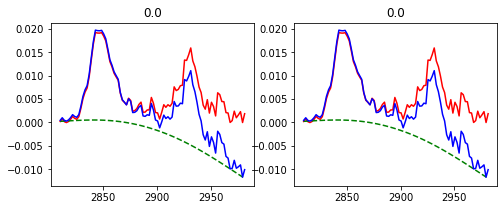

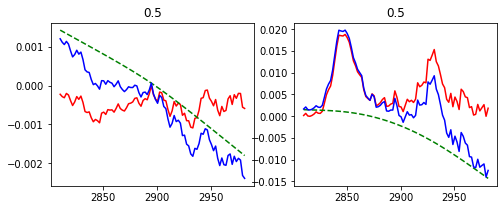

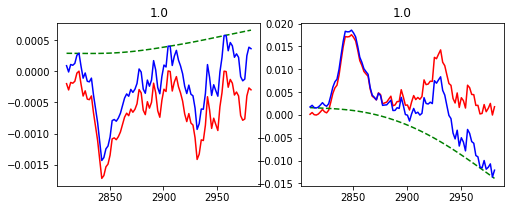

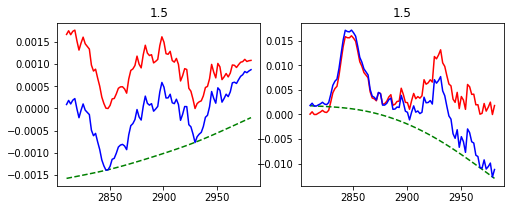

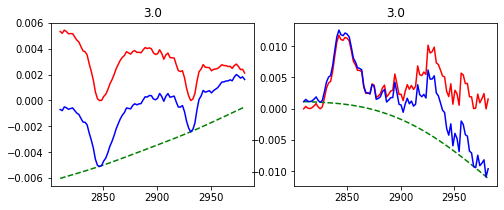

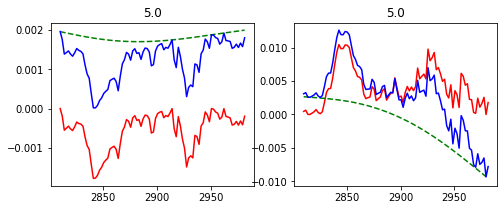

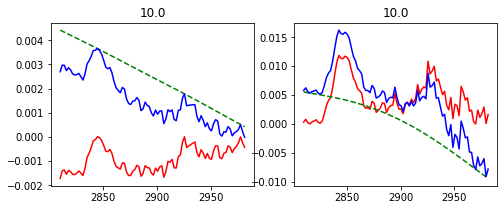

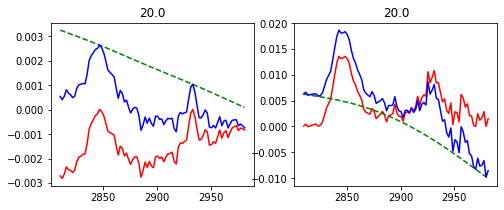

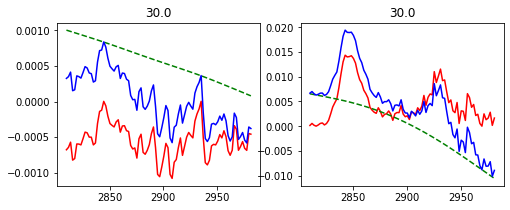

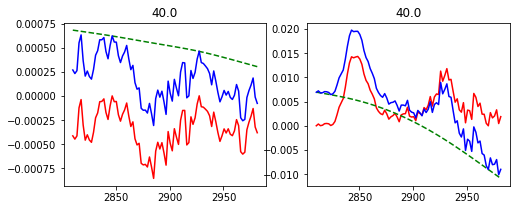

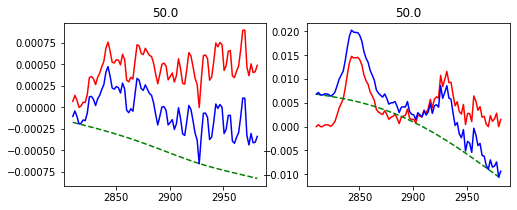

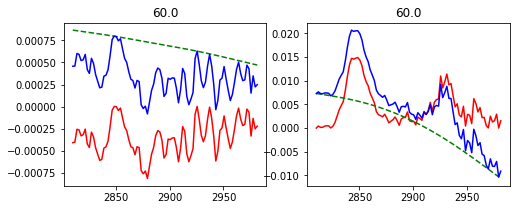

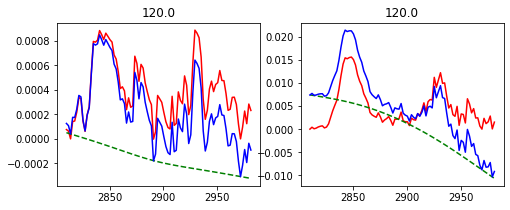

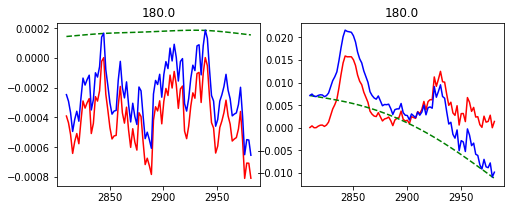

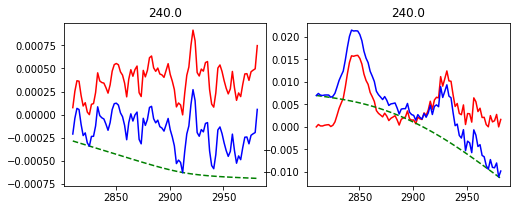

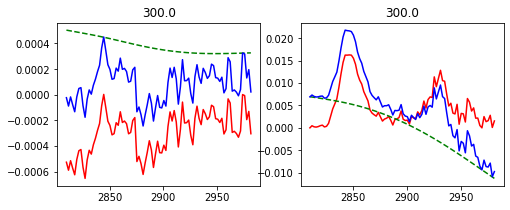

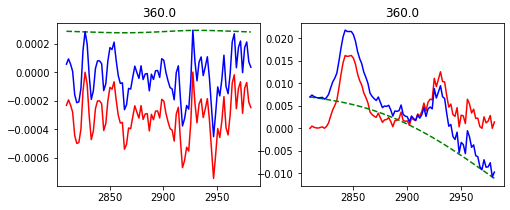

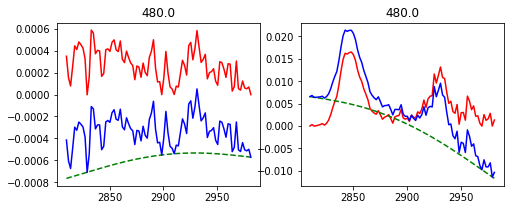

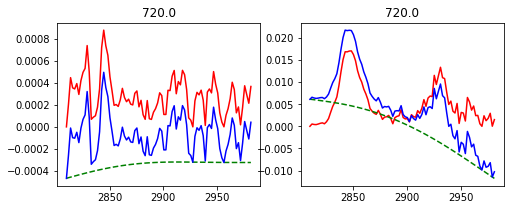

In [4]:

df = pd.read_excel (r'20200914_cleaned.xlsx',sheet_name='dif')
dif = df[df.columns[1:]]
df = pd.read_excel (r'20200914_cleaned.xlsx',sheet_name='acu')
acu = df[df.columns[1:]]
column_num = np.shape(df)[1]
sns.color_palette(n_colors = column_num)
print(dif.columns)
print(acu.columns)

column_num_new = np.shape(dif)[1]
SCH = 1250     #start index of CH 
ECH = 1340     #end index of CH
a = np.transpose(acu[[dif.columns[0]]][SCH:ECH].to_numpy())
WN = a[0]
CH_acu = []
CH_dif = []
time_CH = np.zeros(column_num_new-1)

for i in range(1,column_num_new):
    time_CH[i-1] = get_first_nbr_from_str(dif.columns[i])
    a = np.transpose(dif[[dif.columns[i]]][SCH:ECH].to_numpy())
    a = a[0]
    ##baseline correction
    if a[38] < a[0]:
        print(get_first_nbr_from_str(dif.columns[i]))
        b = -a
        bsl = baseline_als(b, 105, 0.0001)
        y = -(b - bsl)
        bsl = -bsl
    else:
        bsl = baseline_als(a, 105, 0.0001)
        y = a - bsl

    
    a_acu = np.transpose(acu[[dif.columns[i]]][SCH:ECH].to_numpy())[0]
    bsl_acu = baseline_als(a_acu, 105, 0.0001)
    y_acu = a_acu-bsl_acu
    CH_dif.append(y)
    CH_acu.append(y_acu)
    time_CH[i-1] = get_first_nbr_from_str(dif.columns[i])
    fig,ax = plt.subplots(1,2,figsize=(8,3))
    ax[0].plot(WN,y,'r')
    ax[0].plot(WN,bsl,'g--')
    ax[0].plot(WN,a,'b')
    ax[0].set_title(time_CH[i-1])
    ax[1].plot(WN,y_acu,'r')
    ax[1].plot(WN,bsl_acu,'g--')
    ax[1].plot(WN,a_acu,'b')
    ax[1].set_title(time_CH[i-1]) 
print('The fitted region started at {0} cm-1, and ended at {1} cm-1.'.format(WN[0], WN[-1]))
x_CH = np.array(WN)
y_CH = np.array(CH_acu)

In [5]:
column_num_new = np.shape(dif)[1]
S = 455
E = 675
b = np.transpose(dif[[dif.columns[0]]][S:E].to_numpy())
WN = b[0]
CC = []
CC_acu = []
Time = []
for i in range(1,column_num_new):
    a = np.transpose(dif[[dif.columns[i]]][S:E].to_numpy())
    b = np.transpose(acu[[dif.columns[i]]][S:E].to_numpy())
    CC.append(a[0])
    CC_acu.append(b[0])
    Time.append(get_first_nbr_from_str(dif.columns[i]))
x_CC = np.array(WN)
y_CC = np.array(CC)
Time = np.array(Time)
print('The fitted region started at {0} cm-1, and ended at {1} cm-1.'.format(WN[0], WN[-1]))

The fitted region started at 1276.665 cm-1, and ended at 1699.006 cm-1.


1160.955


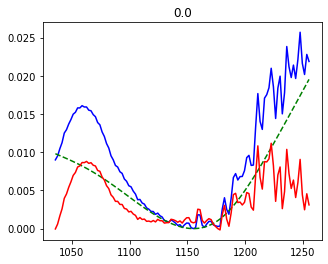

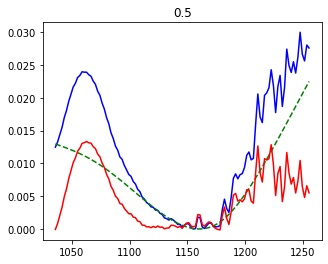

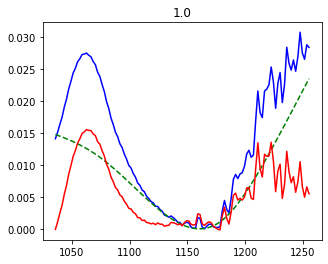

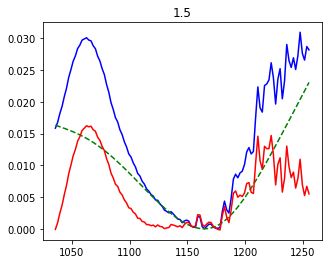

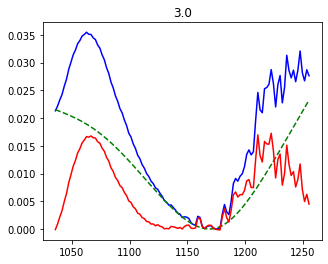

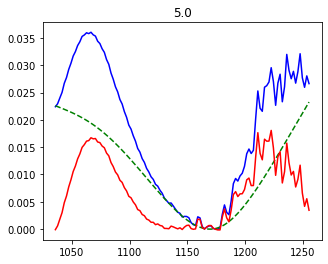

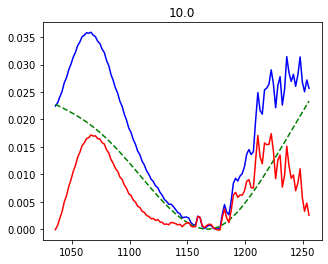

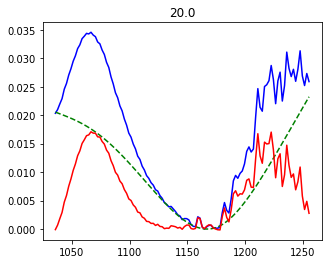

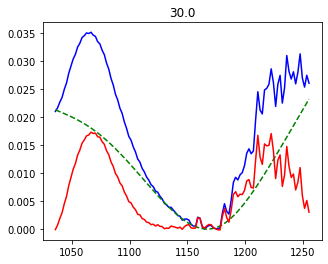

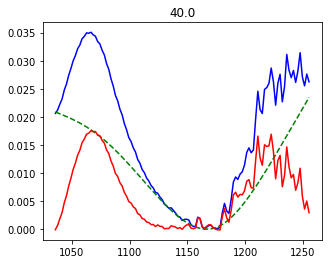

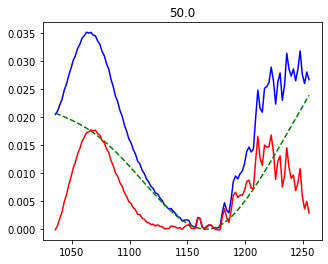

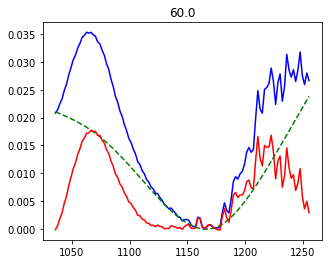

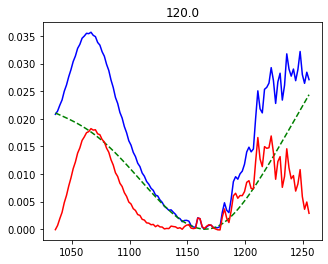

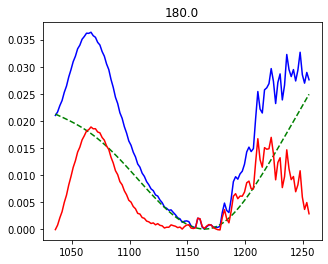

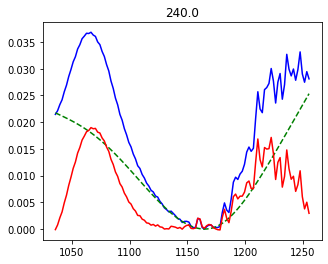

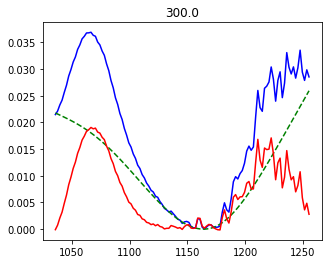

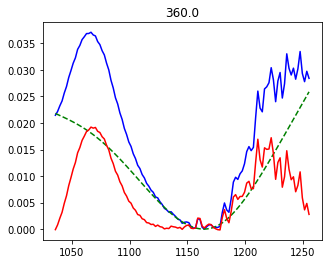

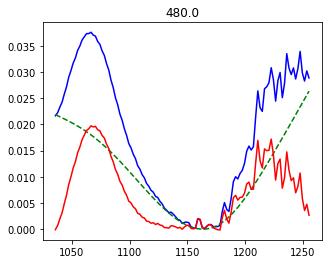

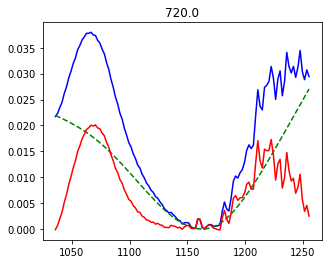

In [6]:
column_num_new = np.shape(dif)[1]
SCO = 330
ECO = 445
LCO = ECO-SCO
b = np.transpose(dif[[dif.columns[0]]][SCO:ECO].to_numpy())
WN = b[0]
CO = []
Min_ind = 65
print(WN[Min_ind])
for i in range(1,column_num_new):
    a = np.transpose(acu[[dif.columns[i]]][SCO:ECO].to_numpy())
    #if i < 5:
    bsl = baseline_als(a[0], 105, 0.0005)
    #bsl2 = baseline_als(a2, 105, 0.0005)
    #else: 
   #     bsl1 = baseline_als(a1, 85,0.00005)
   #     bsl2 = baseline_als(a2, 105, 0.5)
    y = a[0]-bsl

    CO.append(y)
    fig = plt.figure(figsize=(5,4))
    plt.plot(WN,a[0]-a[0].min(),'b-')
    plt.plot(WN,bsl-bsl.min(),'g--')
    plt.plot(WN,CO[-1],'r-')
    plt.title(time_CH[i-1])

x_CO = np.array(WN)
y_CO = np.array(CO)

## Finding a good initial guess

By implementing the lmfit package, we can performance the optimzation of our loss function by minimizing the least square of the difference between the model and actual data. The 'leastsq' method from the lmfit package uses the 'Levenberg-Marquardt' algorithm for the minization. While often criticized, including the fact it finds
a local minima, this approach has some distinct advantages. These include being fast, and well-behaved for most
curve-fitting needs, and making it easy to estimate uncertainties for and correlations between pairs of fit variables. Still the disadvantage of the 'Levenberg-Marquardt' algorithm which is its looking for local minima should be addressed. Hence, the first step in our modeling methodology is finding a reasonable initial guess so that further optimization would have better performances. 

## Fitting the C-H vibrations

In [7]:
Vec_IG = {'Mus':np.array([2861.9,2952,2853.1,2934.2]),
          'Sigmas':np.array([6.7,3.6,4.1,2.9]),
          'Types':np.array([1,1,1,1]),
          'Fixed':None,
          'Lims':None}

In [8]:
print(np.shape(y_CH))

(19, 90)


In [9]:
t0 = time.time()
fit_params_IG = Generate_params_IG(x_CC,Vec_IG,ndata =19)

fitter = Minimizer(loss_func_IG, fit_params_IG, fcn_args=(x_CH, y_CH, Vec_IG))
result = fitter.minimize(method='leastsq')
t1 = time.time() 

print('The time cost is:',t1-t0)

The time cost is: 108.02574300765991


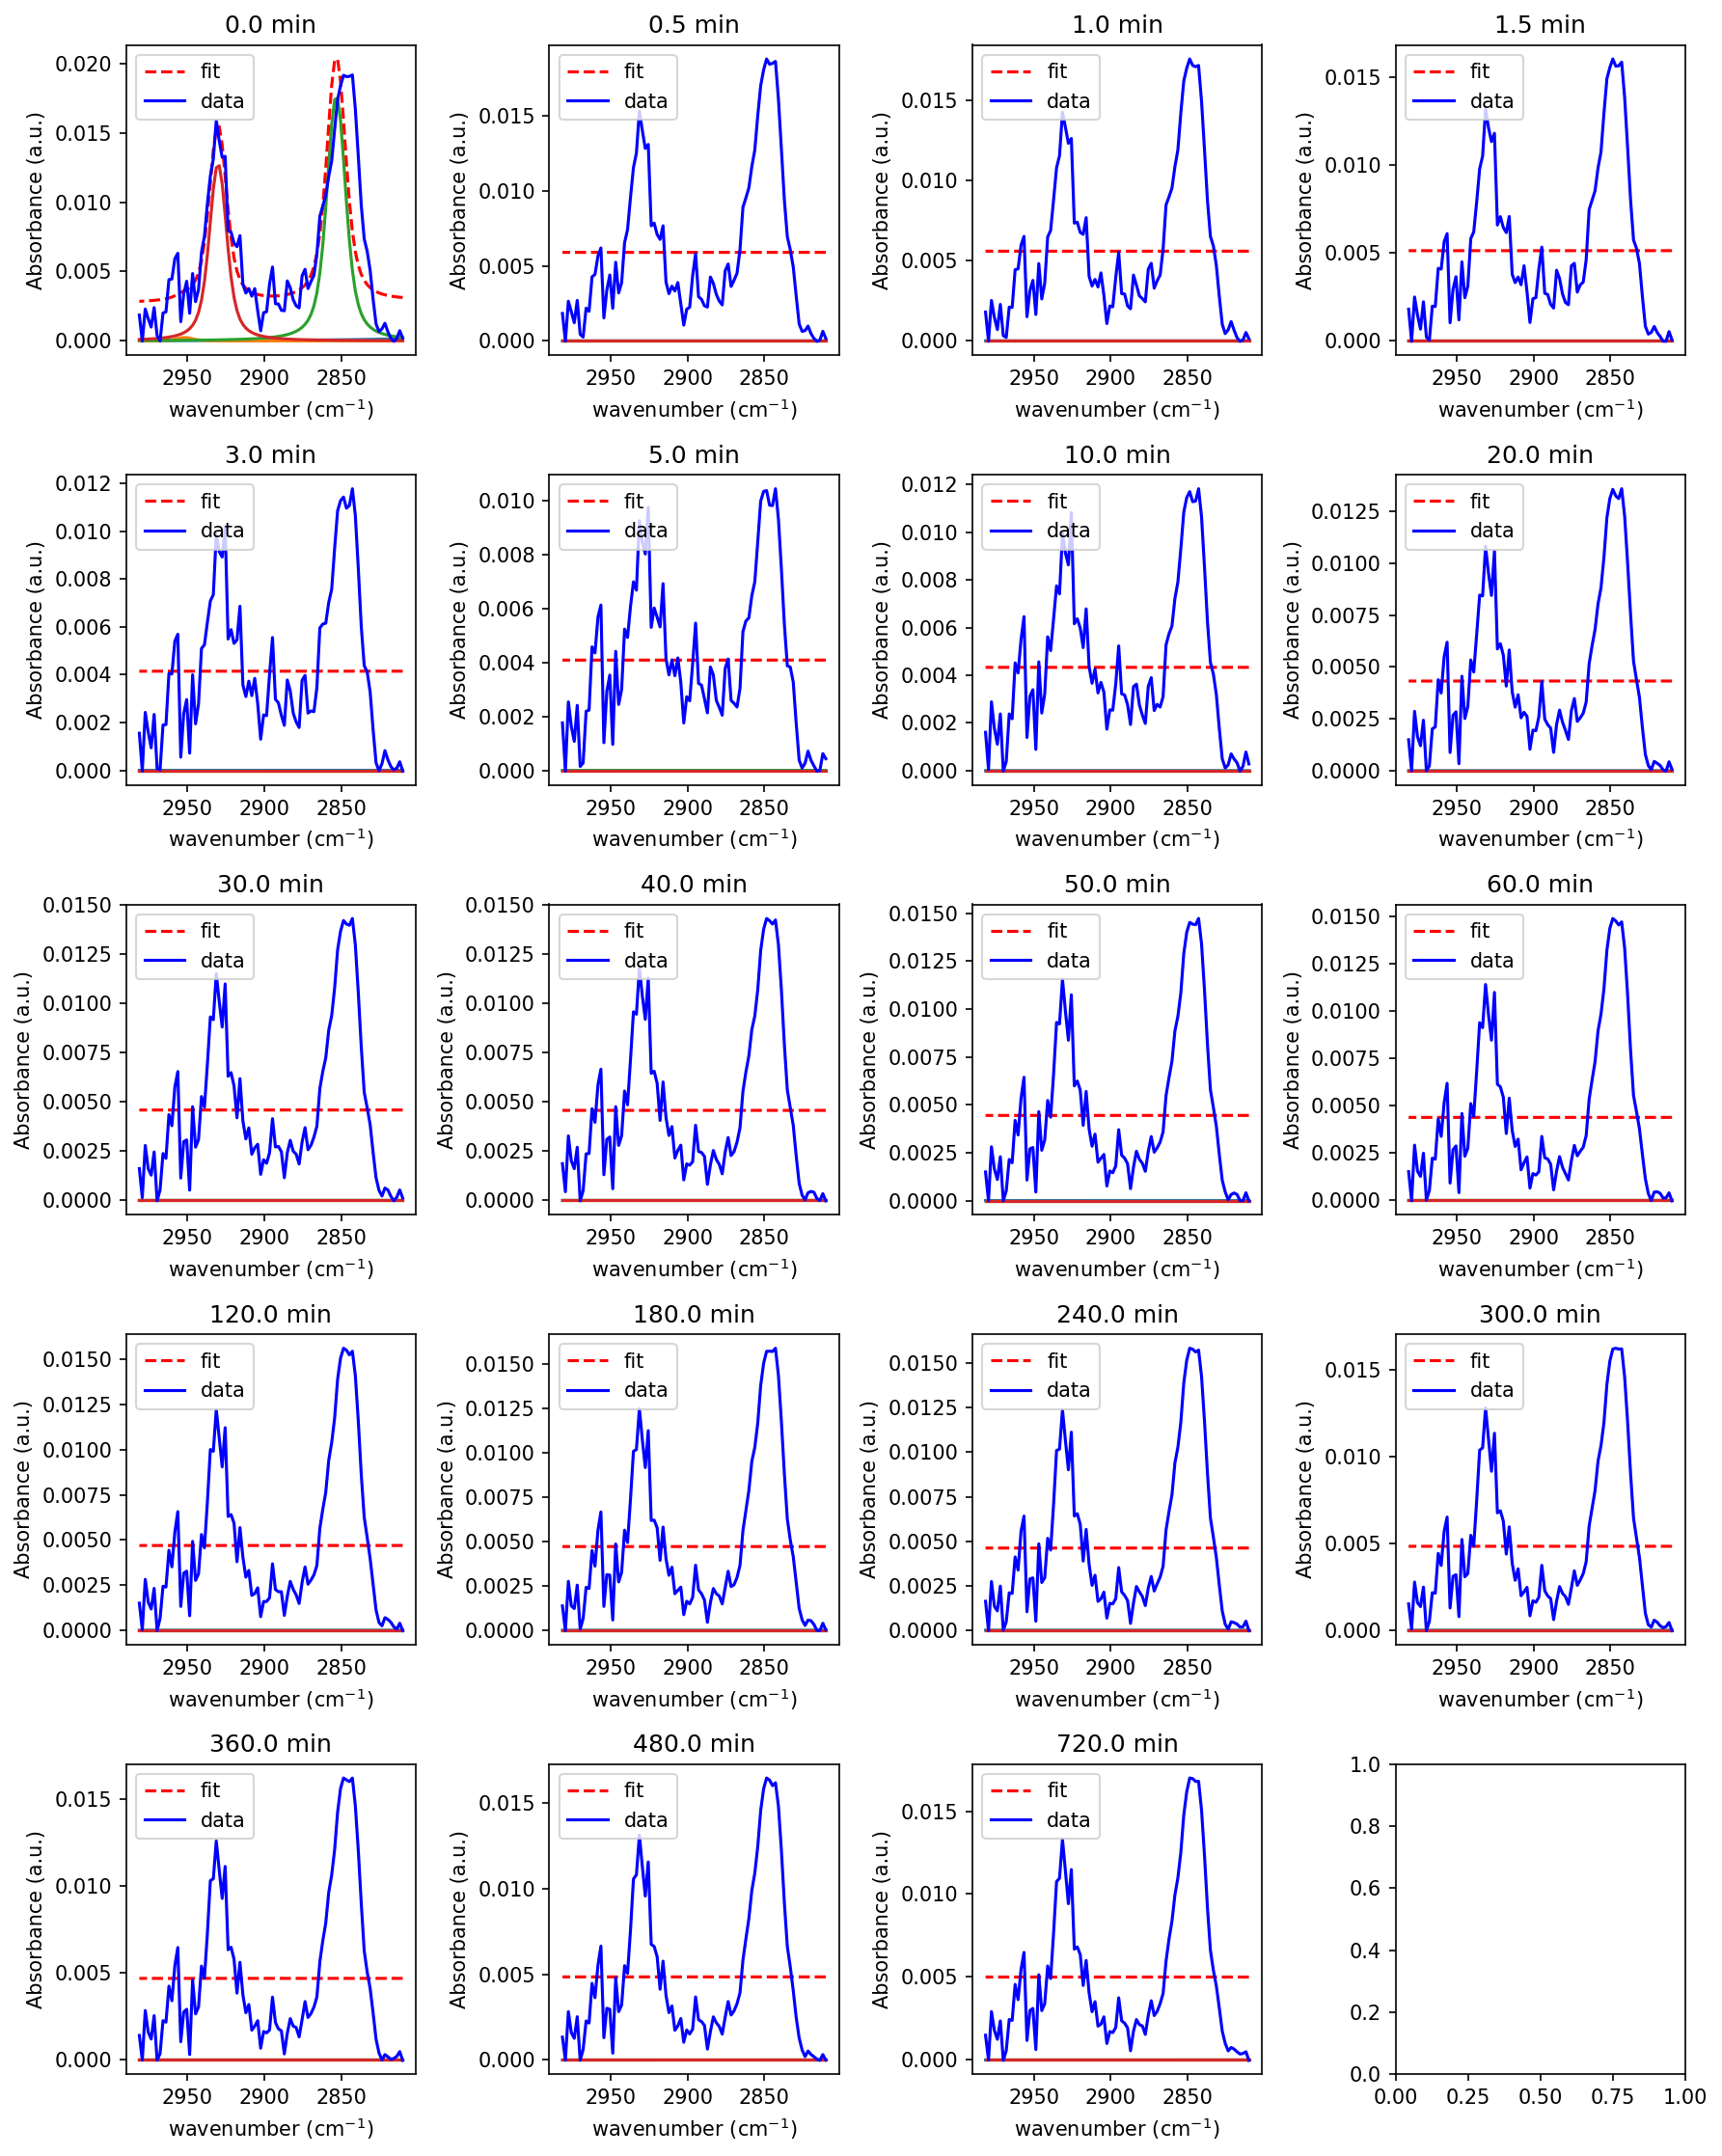

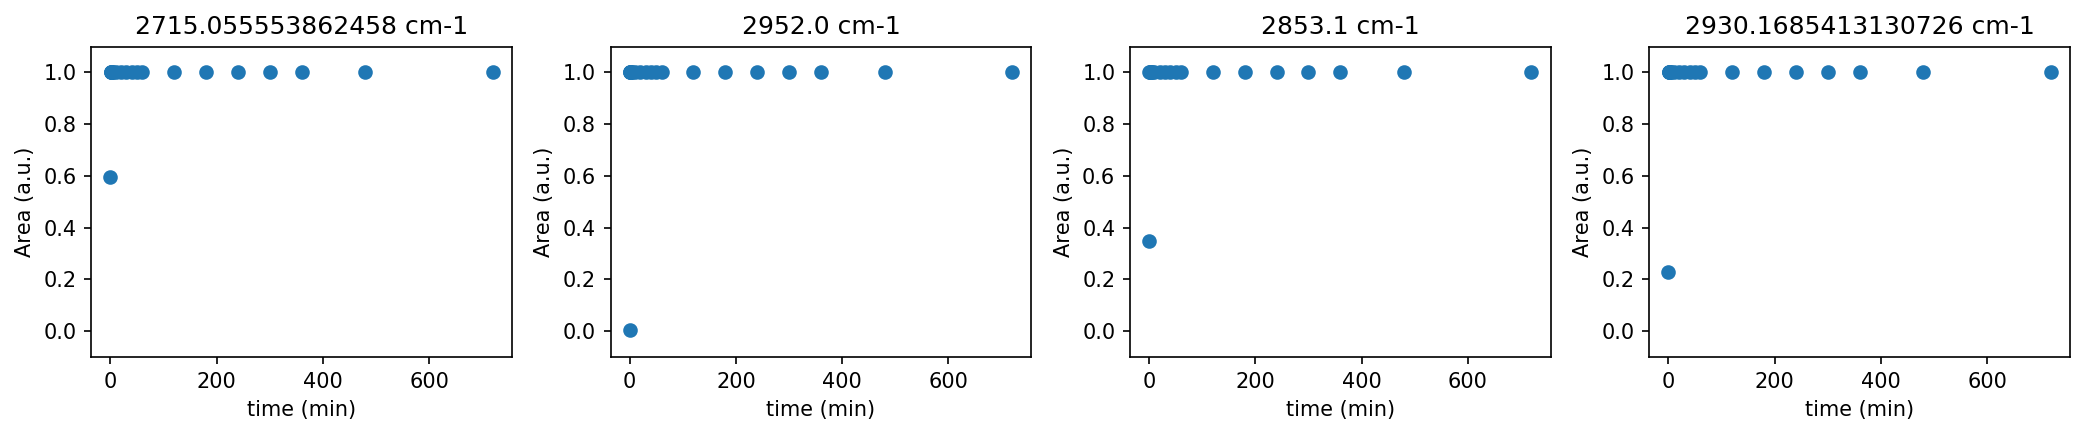

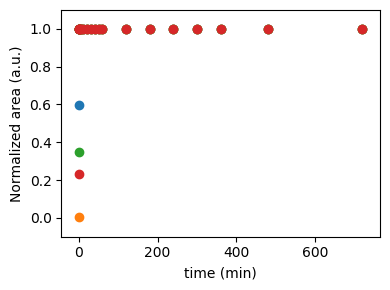

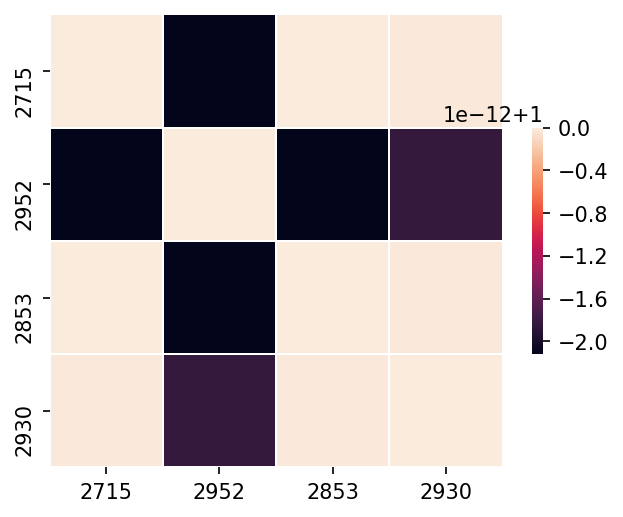

{'Peak Pos': [2715, 2952, 2853, 2930],
 'Amps': array([[0.59496767, 0.00427995, 0.34718764, 0.23044077],
        [1.        , 0.99999795, 1.        , 0.99999988],
        [1.        , 1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        , 1.        ],
        [1.        , 1.  

In [10]:
params_IG = result.params
Plot_data_IG(params_IG,x_CH,y_CH,Vec_IG,time_CH[:19],False)

In [11]:
Vec_IG_struc = {'Peaks':[[0,1,2,3]],'Types':[[1,1,1,1]]}
Vec_fit = Generate_Vec_IG(params_IG,Vec_IG_struc,19)
Vec_fit['Vec0']['Lims'] = {'Peaks':np.array([0,1,2,3]),
                           'Specs':np.array([[0.1,0.1,0.1,0.1],
                                            [4000,4000,4000,4000],
                                            [0.1,.1,0.1,0.1],
                                            [6.5,6.5,6.5,6.5]])}

In [12]:
t0 = time.time()
fit_params = Generate_params(x_CH,Vec_fit,ndata = 19)

fitter = Minimizer(loss_func, fit_params, fcn_args=(x_CH, y_CH, Vec_fit))
result = fitter.minimize(method='leastsq')
t1 = time.time()

print('The time cost is:',t1-t0)

0 8.001818549468773 0.1 6.5
0 2715.055553862458 2695.055553862458 2735.055553862458
0 3.6 0.1 6.5
0 2952.0 2932.0 2972.0
0 4.1 0.1 6.5
0 2853.1 2833.1 2873.1
0 3.7699950259685466 0.1 6.5
0 2930.1685413130726 2910.1685413130726 2950.1685413130726
The time cost is: 9.053107023239136


In [13]:
new_params = result.params
report_fit(new_params)

[[Variables]]
    lin_0:     0.00128695 +/- 3.9327e-04 (30.56%) (init = 0)
    amp_000:   7.01570796 +/- 1364931.26 (19455360.35%) (init = 1.151788)
    cen_000:   2695.05555 +/- 156787.448 (5817.60%) (init = 2715.056)
    sig_000:   0.13288107 +/- 26636.6596 (20045487.84%) (init = 6.5)
    amp_001:   0.03571199 +/- 0.00282067 (7.90%) (init = 1.1152)
    cen_001:   2956.93248 +/- 0.14403837 (0.00%) (init = 2952)
    sig_001:   1.31145083 +/- 0.11490111 (8.76%) (init = 3.6)
    amp_002:   0.52697293 +/- 0.01646100 (3.12%) (init = 1.13644)
    cen_002:   2847.37549 +/- 0.09487420 (0.00%) (init = 2853.1)
    sig_002:   5.81875398 +/- 0.09483129 (1.63%) (init = 4.1)
    amp_003:   0.29790639 +/- 0.00954496 (3.20%) (init = 1.129209)
    cen_003:   2929.82366 +/- 0.11769104 (0.00%) (init = 2930.169)
    sig_003:   4.66190917 +/- 0.09949688 (2.13%) (init = 3.769995)
    lin_1:     0.00140454 +/- 3.8029e-04 (27.08%) (init = 0)
    amp_100:   6.71481853 +/- 1306338.76 (19454565.36%) (init = 3.9

Plotting.....


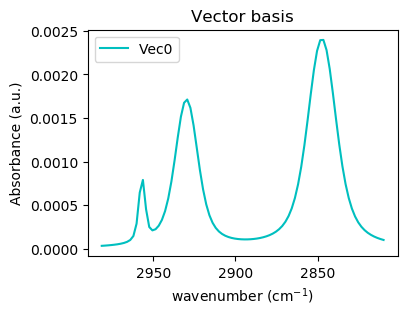

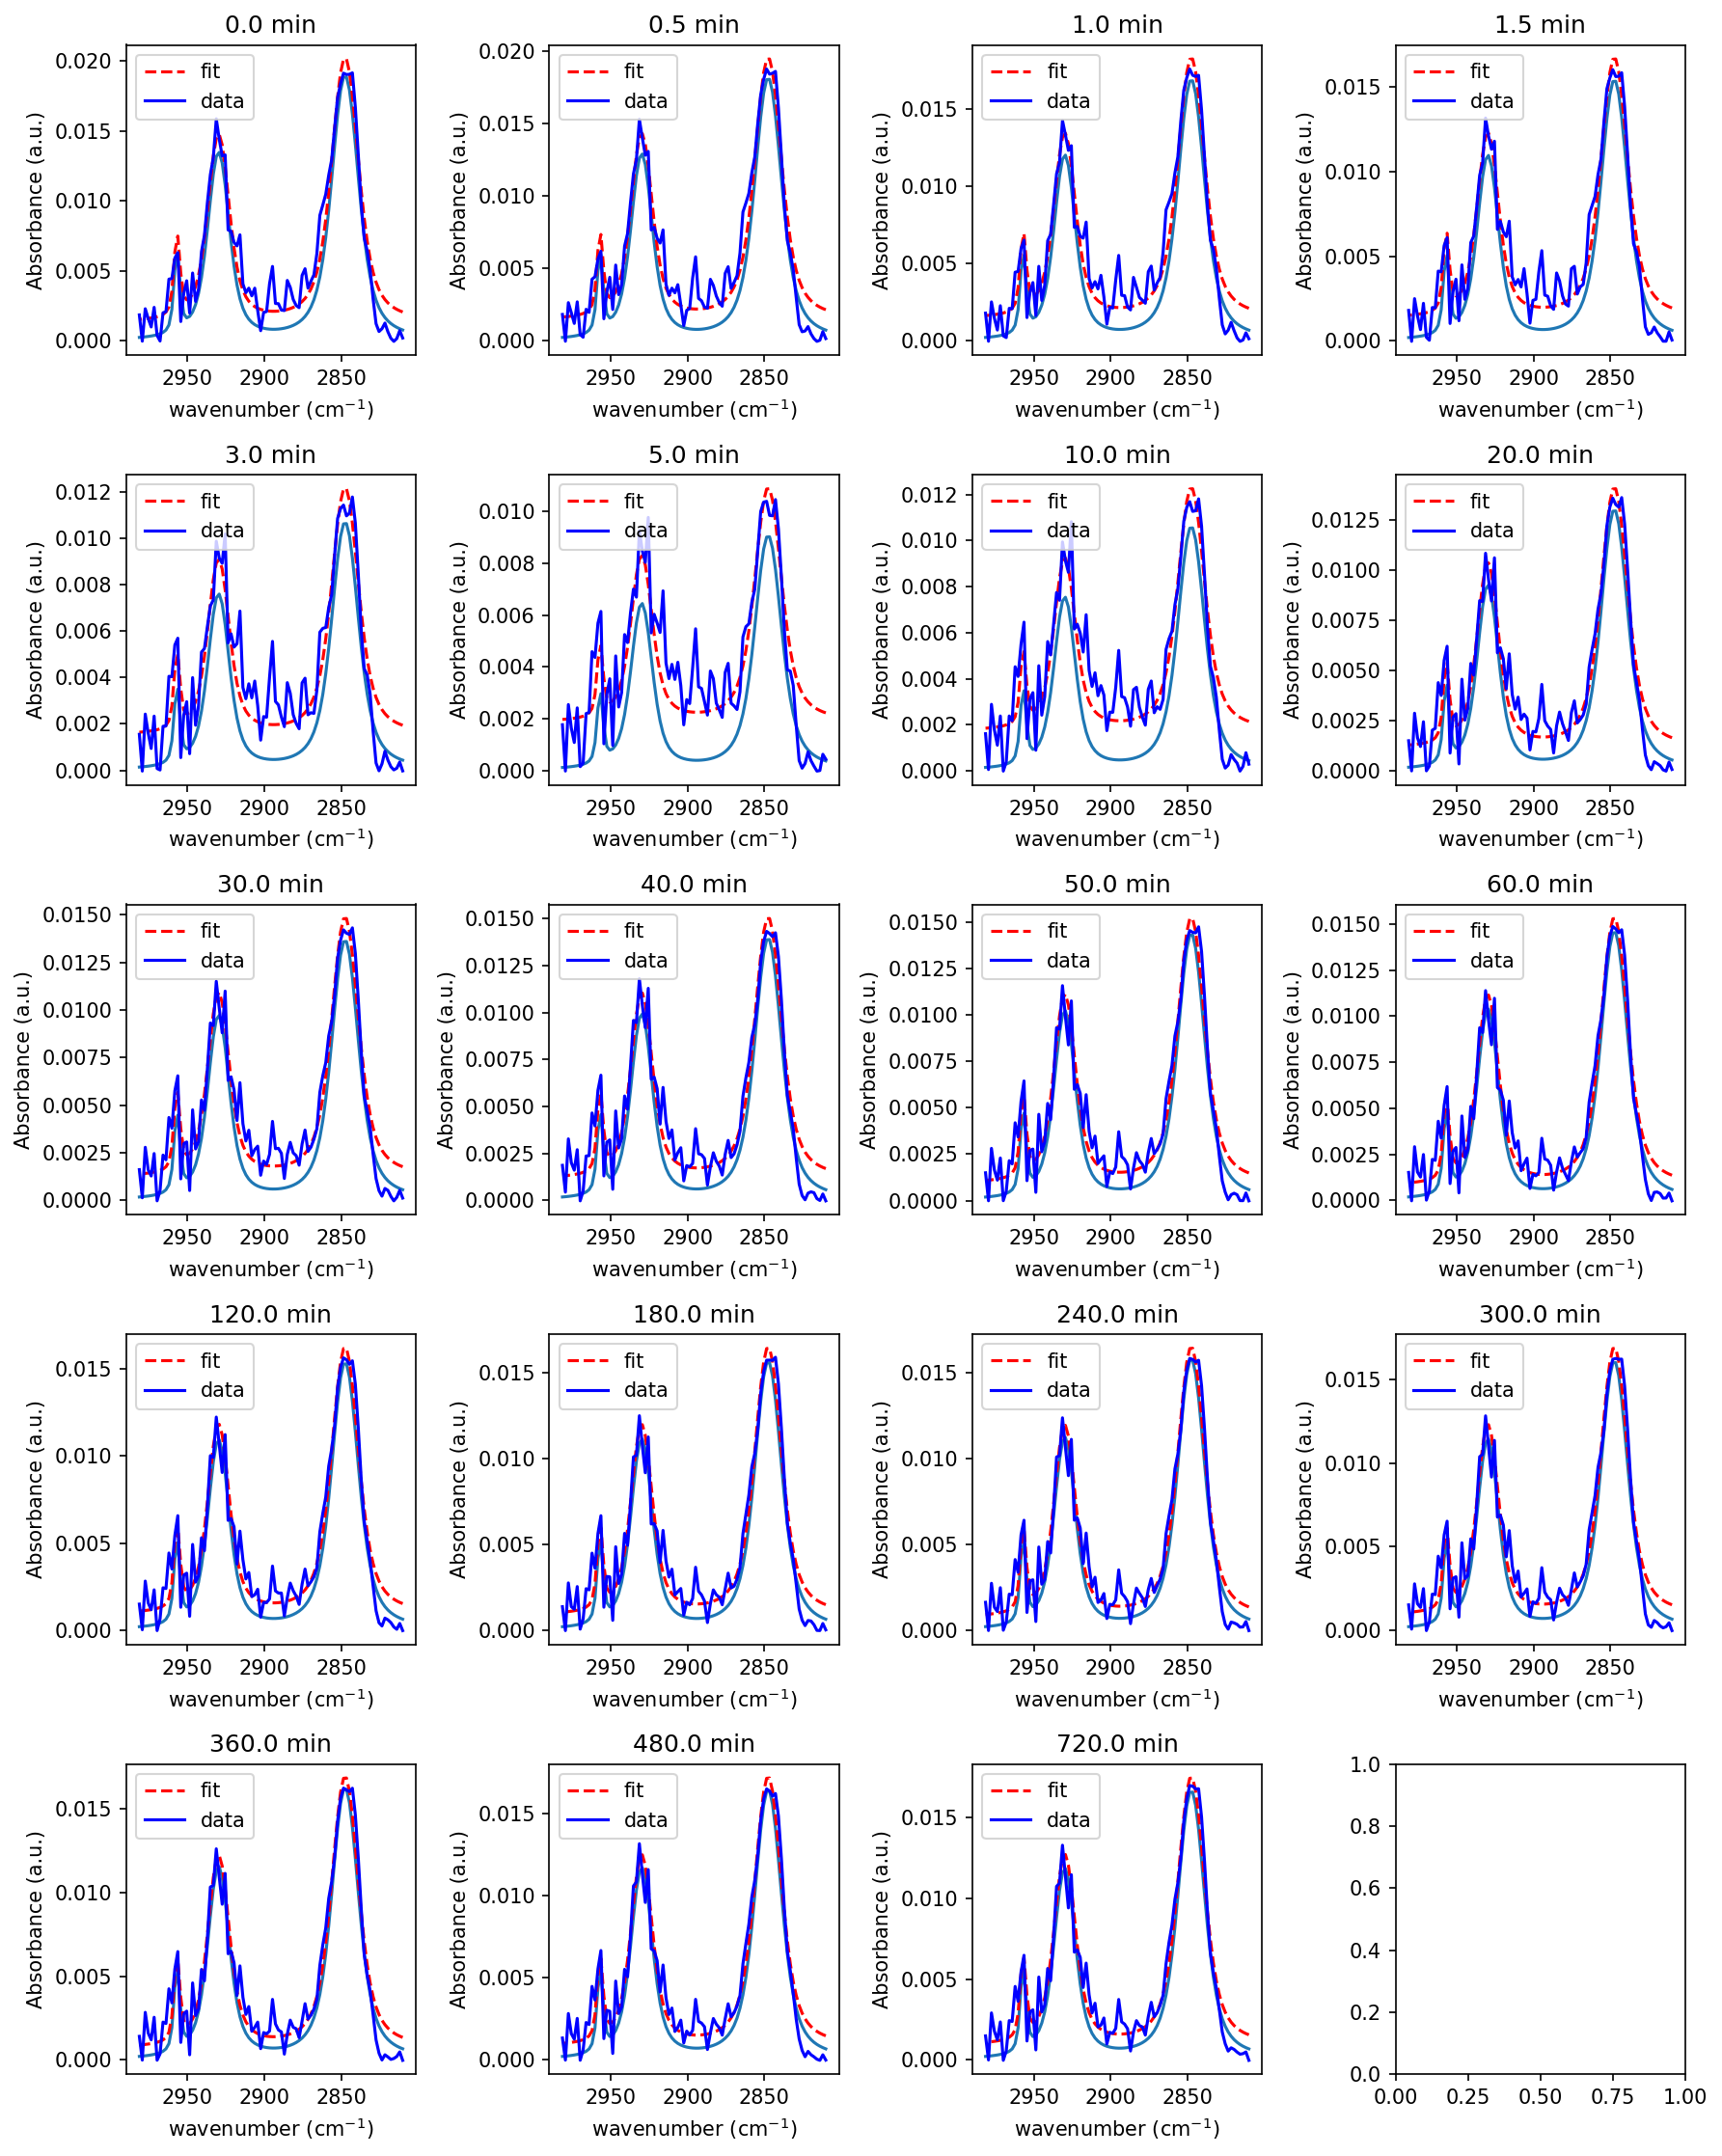

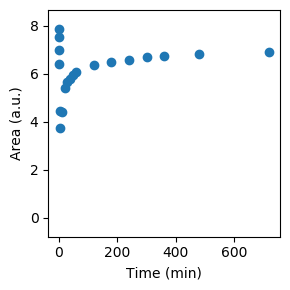

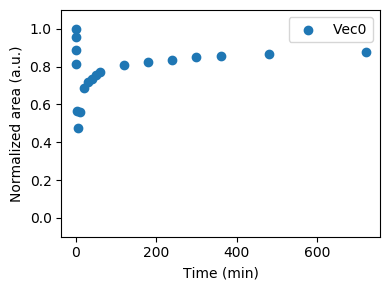

In [14]:
Plot_data(new_params,x_CH,y_CH,Vec_fit,time_CH[:19],False)

## Fitting the 1300-1700 cm$^{-1}$ region

We want to include a peak around 1600 cm$^{-1}$ as the C=O species, two peaks around 1540 cm$^{-1}$ for carbonates, 4 peaks around 1300 cm$^{-1}$ to 1500 cm$^{-1}$ for aromatics and finally, a two peaks around 1350 cm$^{-1}$ for the formates.

We wanna repeat the previous procedure, i.e.:

    1) Make an initial guess on all the peaks
    2) Group the peaks and creat a vector space
    3) Use the new vector basis to perform non-linear regression fit for optimization of the parameters
   


### Fitting the initial stage (0,10) min

We use postfix _CC0 for fitting of this period.

Below is an intial guess of the peaks.

In [18]:
Vec_IG_CC0 = {'Mus':np.array([1600.5,1544.5,1548.3,1488.25,1424.5, 1349.9,1371.1,1357.8,1304]),
             'Sigmas':np.array([10,3.624,17.8,13.4,17.9, 22.9,1.764,4.375,2]),
             'Types':np.array([1,0,1,1,1,1,0,0,0]),
             'Fixed':None,#np.array([0,0,0,0,0,0,0,1,1,1]),
             'Lims':{'Positive':True,
                     'Mus_min':np.array([1590,1537., 1500., 1460, 1370,1330, 1300, 1330, 1300.])}             
             }


In [19]:
t0 = time.time()
ndata = 4
fit_params_IG = Generate_params_IG(x_CC,Vec_IG_CC0,ndata = ndata)
fitter = Minimizer(loss_func_IG, fit_params_IG, fcn_args=(x_CC, y_CC[:ndata], Vec_IG_CC0))
result = fitter.minimize(method='leastsq')
t1 = time.time() 

print('The time cost is:',t1-t0)


The time cost is: 329.73359990119934


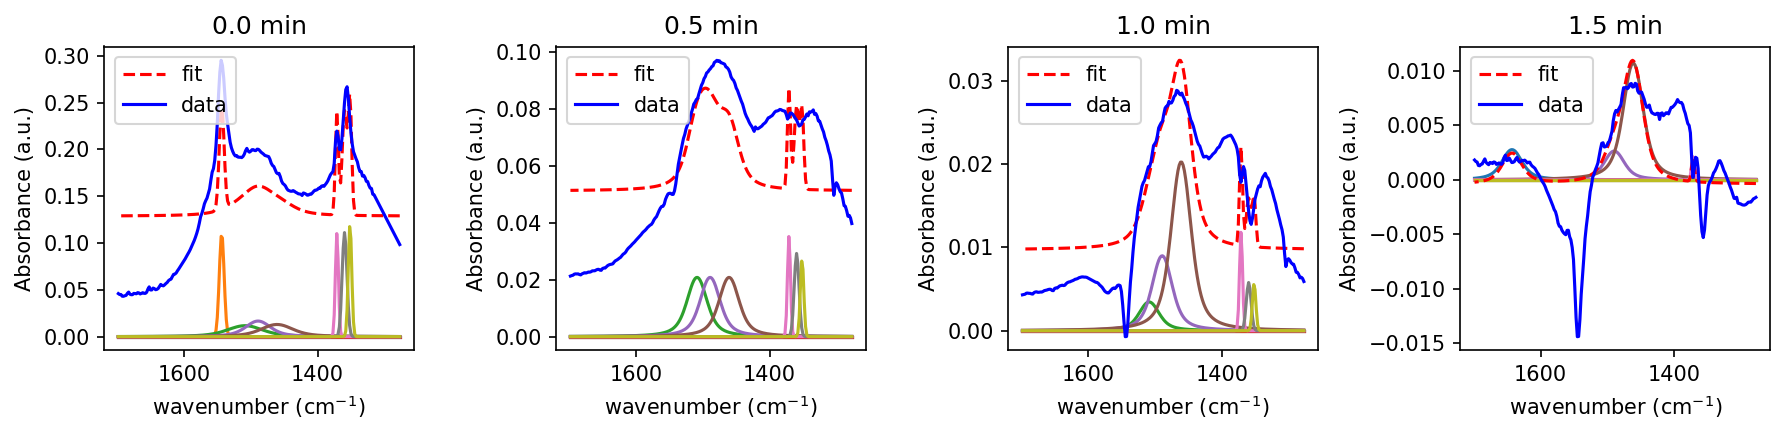

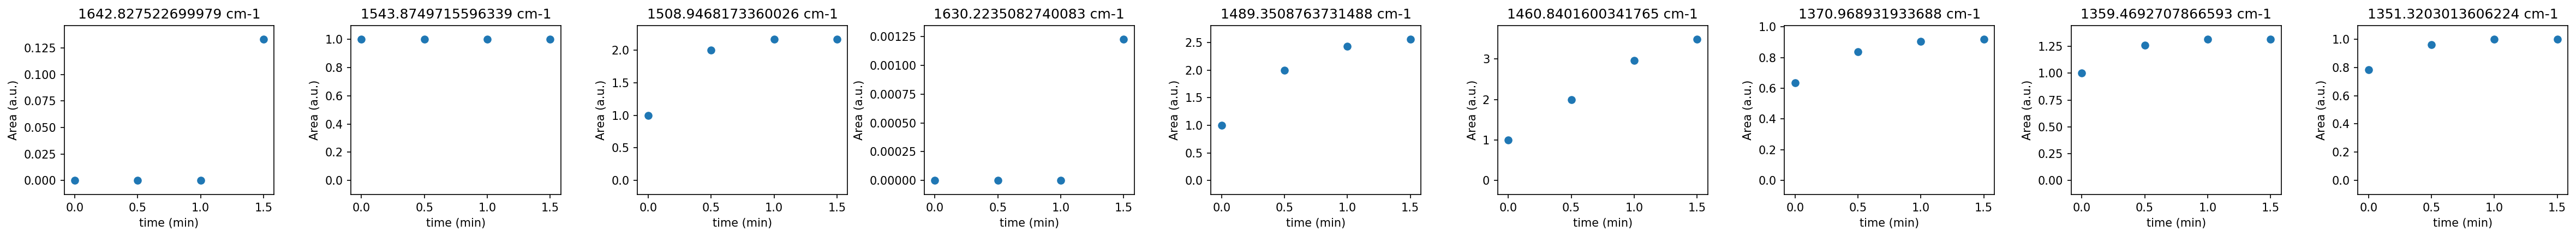

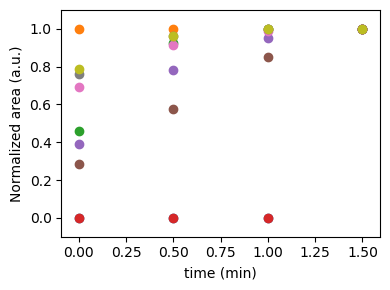

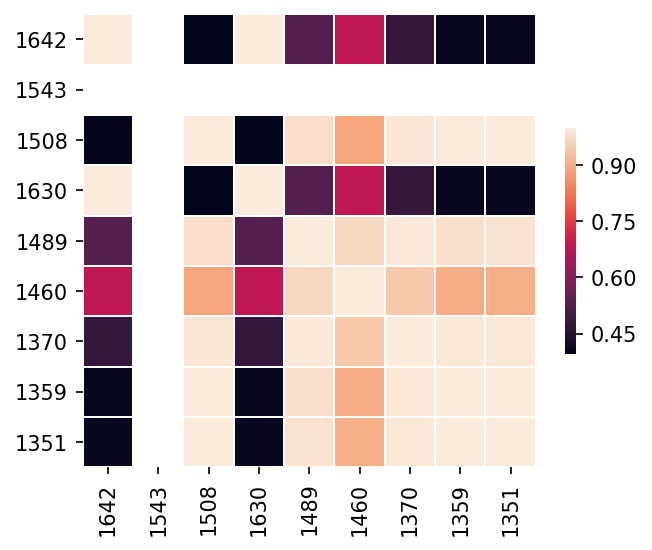

{'Peak Pos': [1642, 1543, 1508, 1630, 1489, 1460, 1370, 1359, 1351],
 'Amps': array([[8.80085274e-07, 1.00000000e+00, 1.00000000e+00, 1.35891298e-13,
         1.00000000e+00, 1.00000000e+00, 6.34802106e-01, 1.00000000e+00,
         7.83438025e-01],
        [8.80085296e-07, 1.00000000e+00, 2.00000000e+00, 1.77857729e-13,
         2.00000000e+00, 2.00000000e+00, 8.38015137e-01, 1.26343265e+00,
         9.60780410e-01],
        [8.80085296e-07, 1.00000000e+00, 2.16574737e+00, 1.77913240e-13,
         2.43162056e+00, 2.97234268e+00, 9.06187503e-01, 1.31553758e+00,
         9.97731296e-01],
        [1.32938446e-01, 1.00000000e+00, 2.16574737e+00, 1.22660953e-03,
         2.55838220e+00, 3.48628954e+00, 9.18426816e-01, 1.31553758e+00,
         9.97731296e-01]])}

In [21]:
params_IG = result.params
Plot_data_IG(params_IG,x_CC,y_CC[:ndata],Vec_IG_CC0,time_CH[:ndata],True)

Now we want to creat a frame of the vector space, i.e. we need to define how many vectors are there and which peaks belong to which vector.

In [37]:
Vec_IG_CC0 = {'Peaks':np.array([[0],[1,2],[3,4,5],[6,7],[8]]),
              'Types':np.array([[1],[0,1],[1,1,1],[0,0],[0]])}
Vec_fit_CC0 = Generate_Vec_IG(params_IG,Vec_IG_CC0,ndata)
#Vec_fit['Vec0']['Lims'] = {'Peaks':np.array([0,1,2,3]),
#                           'Specs':np.array([[0.1,0.1,0.1,0.1],
#                                            [4000,4000,4000,4000],
#                                            [0.1,.1,0.1,0.1],
#                                            [6.5,6.5,6.5,6.5]])}


In [58]:
def Generate_params(x,Vec,ndata):
    params = Parameters()
    nvec = len(Vec)-1
    if Vec['Alphas'] is None:
        alpha = np.ones((nvec,ndata))*0.1
    else:
        ndata = np.shape(Vec['Alphas'])[1]
        alpha = Vec['Alphas']
    y = np.zeros((ndata,len(x)))
    Min = x.min()
    Max = x.max()
    for i in range(ndata):
        params.add('lin_{}'.format(i), value=0, min=-1, max =1)
        for j in range(nvec):
            npeak = len(Vec['Vec{}'.format(j)]['Mus'])
            if Vec['Vec{}'.format(j)]['Lims'] is None:
                auto = True
            else:    
                auto = False
            for k in range(npeak):
                mu = Vec['Vec{}'.format(j)]['Mus'][k]
                sigma = Vec['Vec{}'.format(j)]['Sigmas'][k]
                if Vec['Vec{}'.format(j)]['Types'][k]:
                    sigma_max_hard = 25.
                    mu_const = 30.
                    sigma_const = 15.
                else: 
                    sigma_max_hard = 6.5
                    mu_const = 5.
                    sigma_const = 5.
                mu_min = mu - mu_const
                mu_max = mu + mu_const
                sigma_min = max(0.1,sigma - sigma_const)
                sigma_max = sigma + sigma_const
                amp_min = -10
                amp_min_k = -10
                if auto == False: 
                    if k in Vec['Vec{}'.format(j)]['Lims']['Peaks']:
                        index = np.where(Vec['Vec{}'.format(j)]['Lims']['Peaks'] == k)[0][0]
                        mu_min = max(mu_min, Vec['Vec{}'.format(j)]['Lims']['Specs'][0,index])
                        mu_max = min(mu_max, Vec['Vec{}'.format(j)]['Lims']['Specs'][1,index])
                        sigma_min = max(0.1, sigma_min, Vec['Vec{}'.format(j)]['Lims']['Specs'][2,index])
                        sigma_max = min(sigma_max, Vec['Vec{}'.format(j)]['Lims']['Specs'][3,index], sigma_max_hard)
                        amp_min = max(-10, Vec['Vec{}'.format(j)]['Lims']['Specs'][4,index])

                if i == 0:
                    amp = Vec['Vec{}'.format(j)]['Amps'][k]*alpha[j,i]
                    print(j,sigma,sigma_min,sigma_max)
                    print(j,mu,mu_min,mu_max)
                    params.add('amp_{}{}{}'.format(i,j,k), value=amp, min=amp_min,  max=10)
                    params.add('cen_{}{}{}'.format(i,j,k), value=mu, min=mu_min,  max=mu_max)
                    params.add('sig_{}{}{}'.format(i,j,k), value=sigma, min=sigma_min,  max=sigma_max)
                else: 
                    if k == 0:
                        if Vec['Vec{}'.format(j)]['Lims'] is not None:
                            if Vec['Vec{}'.format(j)]['Lims']['Pos'] is not None:
                                if Vec['Vec{}'.format(j)]['Lims']['Pos'][k]:
                                    amp_min_k = 0
                        amp = Vec['Vec{}'.format(j)]['Amps'][k]*alpha[j,i]
                        params.add('amp_{}{}{}'.format(i,j,k), value=amp, min=amp_min_k,  max=10)
                    else:
                        a = params['amp_{}{}{}'.format(i,j,0)].value
                        b = params['amp_{}{}{}'.format(0,j,k)].value
                        c = params['amp_{}{}{}'.format(0,j,0)].value
    
                        amp = a*b/c
                        params.add('amp_{}{}{}'.format(i,j,k), min=-10,  max=10,
                                   expr = 'amp_{}{}{}*amp_{}{}{}/amp_{}{}{}'.format(i,j,0,0,j,k,0,j,0))

                    params.add('cen_{}{}{}'.format(i,j,k), min=mu_min,  max=mu_max, expr='cen_{}{}{}'.format(0,j,k))
                    params.add('sig_{}{}{}'.format(i,j,k), min=sigma_min,  max=sigma_max, expr='sig_{}{}{}'.format(0,j,k))
                if Vec['Vec{}'.format(j)]['Types'][k]:
                    y[i] = y[i] + Voigt(x,amp,mu,sigma)
                else: 
                    y[i] = y[i] + Gaussian(x,amp,mu,sigma)
                #print('{}{}{}\t{}\t{}\t{}'.format(i,j,k,amp,mu,sigma))
    return params

In [44]:
t0 = time.time()
Vec_fit_CC0['Alphas'] = None
Vec_fit_CC0['Vec0']['Lims'] = {'Peaks':np.array([0]),'Specs':np.array([[0],[4000],[0.1],[20],[0]]),'Pos':[True]}
#Vec_fit_CC0['Vec3']['Lims'] = {'Peaks':np.array([0,1]),'Specs':np.array([[0,0],[4000,4000],[1.2,1.2],[4,4],[-10,-10]])}
fit_params_CC0 = Generate_params(x_CC,Vec_fit_CC0,ndata =ndata)

fitter = Minimizer(loss_func, fit_params_CC0, fcn_args=(x_CC, y_CC[:ndata], Vec_fit_CC0))
result = fitter.minimize(method='leastsq')
t1 = time.time() 

print('The time cost is:',t1-t0)

0 12.42242865476835 0.1 20.0
0 1590.0 1560.0 1620.0
1 3.624 0.1 8.624
1 1537.3187234594832 1532.3187234594832 1542.3187234594832
1 17.8 2.8000000000000007 32.8
1 1673.4804226881904 1643.4804226881904 1703.4804226881904
2 9.381088170905238 0.1 24.381088170905237
2 1535.825970555125 1505.825970555125 1565.825970555125
2 21.049445606838308 6.049445606838308 36.049445606838304
2 1468.533937853286 1438.533937853286 1498.533937853286
2 16.030000000000292 1.0300000000002925 31.030000000000292
2 1391.2734243358188 1361.2734243358188 1421.2734243358188
3 2.293199999996125 0.1 7.293199999996125
3 1369.4087684852152 1364.4087684852152 1374.4087684852152
3 5.687499999999439 0.6874999999994387 10.687499999999439
3 1356.6860000570964 1351.6860000570964 1361.6860000570964
4 1.400000000000001 0.1 6.400000000000001
4 1305.9041773330187 1300.9041773330187 1310.9041773330187
The time cost is: 592.0309221744537


The score of the fit is: 0.003480348638522342
Plotting.....


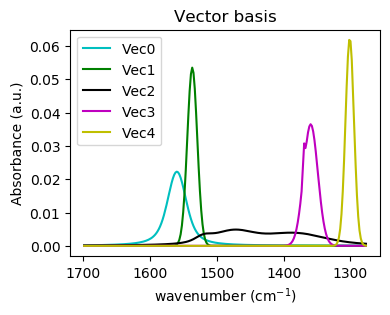

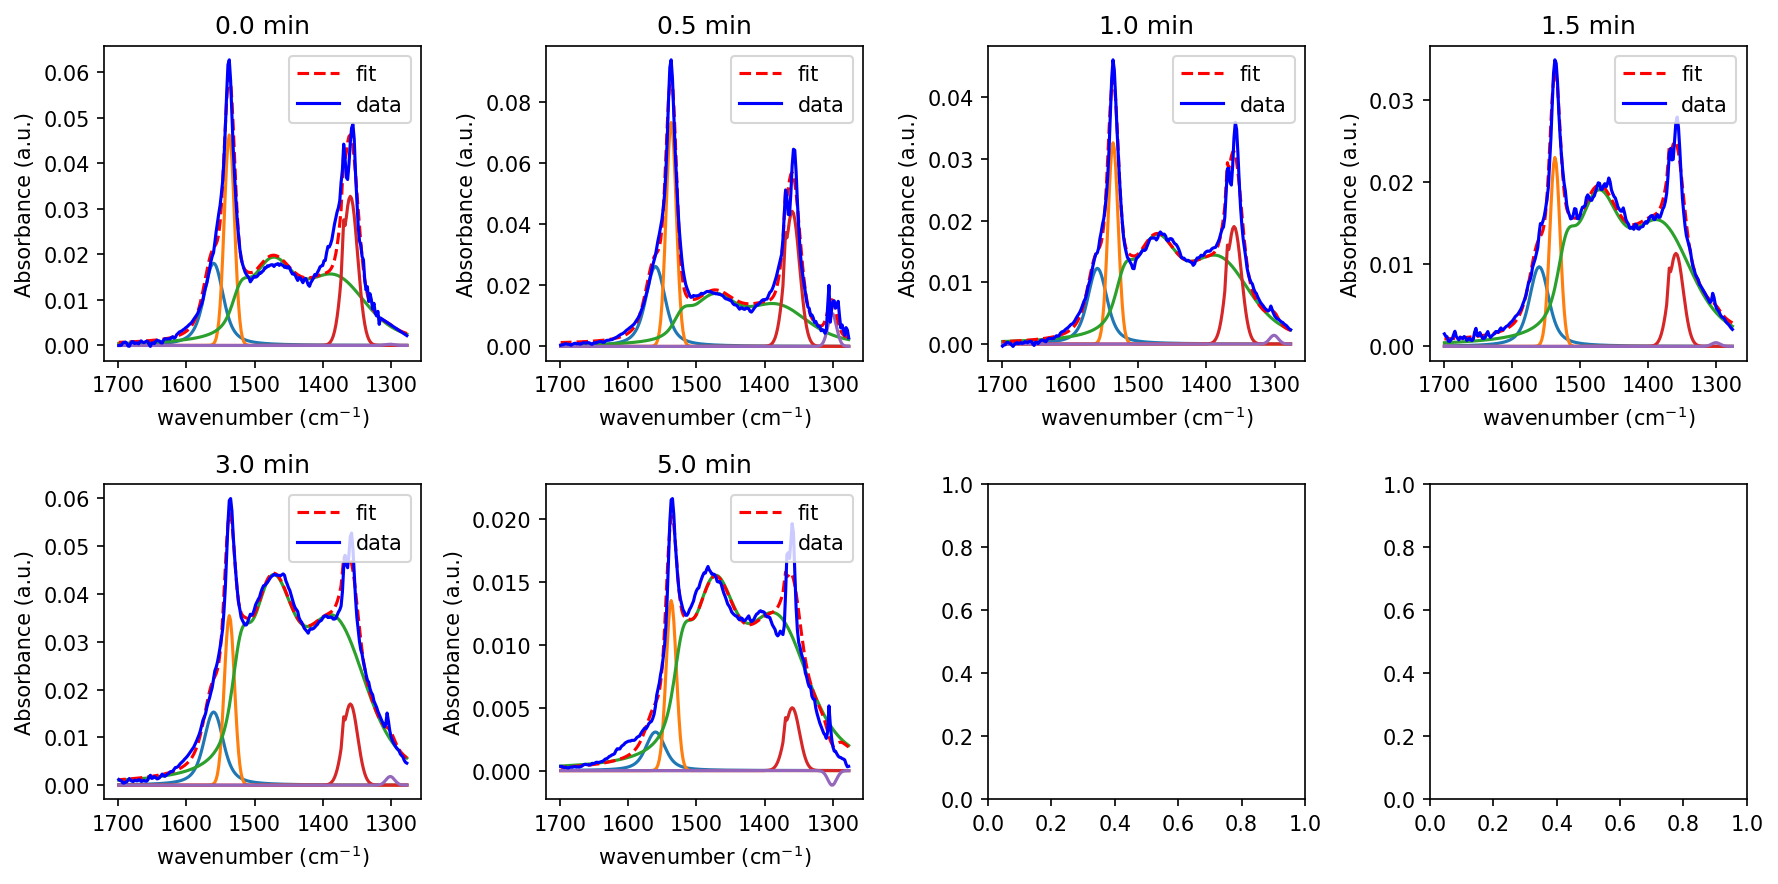

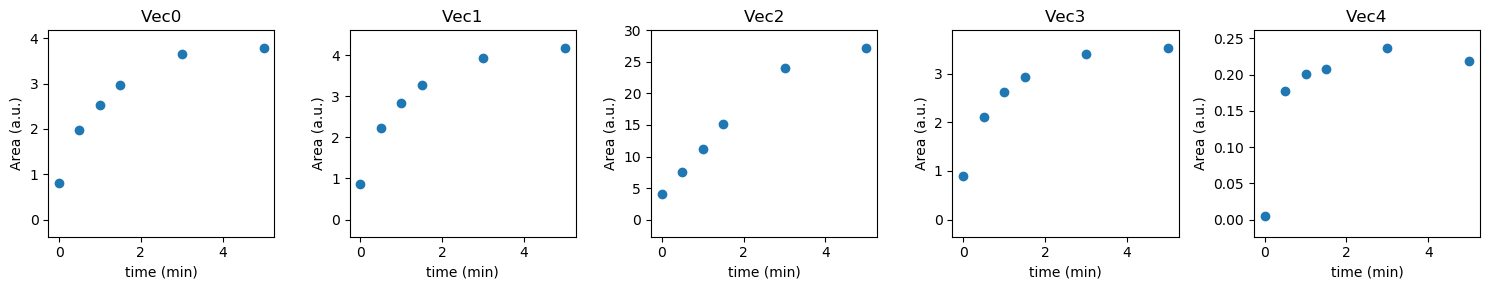

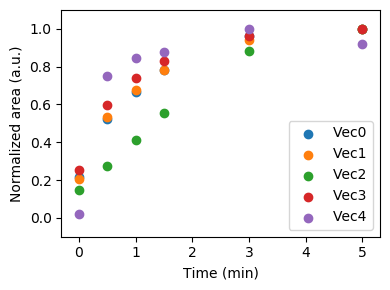

In [45]:
new_params0 = result.params
print('The score of the fit is:', result.chisqr)
Plot_data(new_params0,x_CC,y_CC[:ndata],Vec_fit_CC0,time_CH[:ndata],True)

### Fitting the Middle Stage (20,120) min

We use postfix _CC1 for fitting of this period.

Below is an intial guess of the peaks.

In [56]:
Vec_CC_IG1 = {'Mus':np.array([1601.5,1544.5,1548.3,1488.25,1424.5, 1349.9,1371.1,1357.8,1304]),
             'Sigmas':np.array([10,3.624,17.8,13.4,17.9, 22.9,1.764,4.375,2]),
             'Types':np.array([1,0,1,1,1,1,0,0,0]),
             'Fixed':None,#np.array([0,0,0,0,0,0,0,1,1,1]),
             'Lims':{'Positive':False,
                     'Mus_min':np.array([1595,1537., 1500., 1460, 1370,1330, 1300, 1330, 1300.])}
             }


In [57]:
t0 = time.time()
nstart = 6
ndata = 4

fit_params_IG1 = Generate_params_IG(x_CC,Vec_CC_IG1,ndata = ndata)

fitter = Minimizer(loss_func_IG, fit_params_IG1, fcn_args=(x_CC, y_CC[nstart:nstart+ndata], Vec_CC_IG1))
result = fitter.minimize(method='leastsq')
t1 = time.time() 

print('The time cost is:',t1-t0)

The time cost is: 8.747858047485352


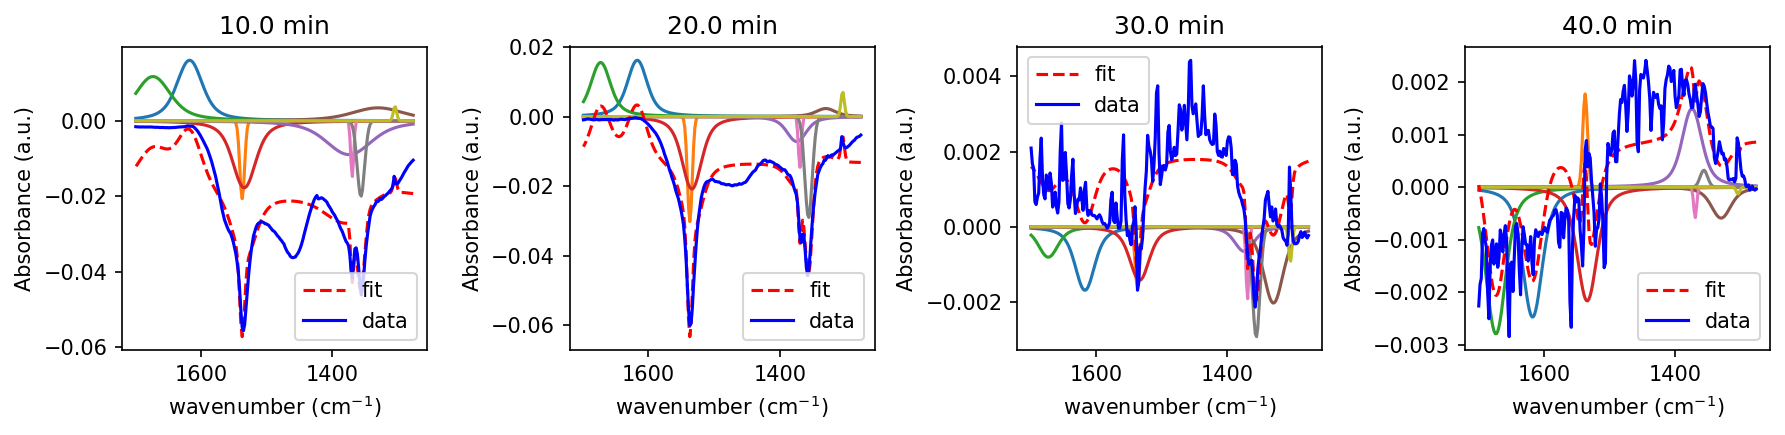

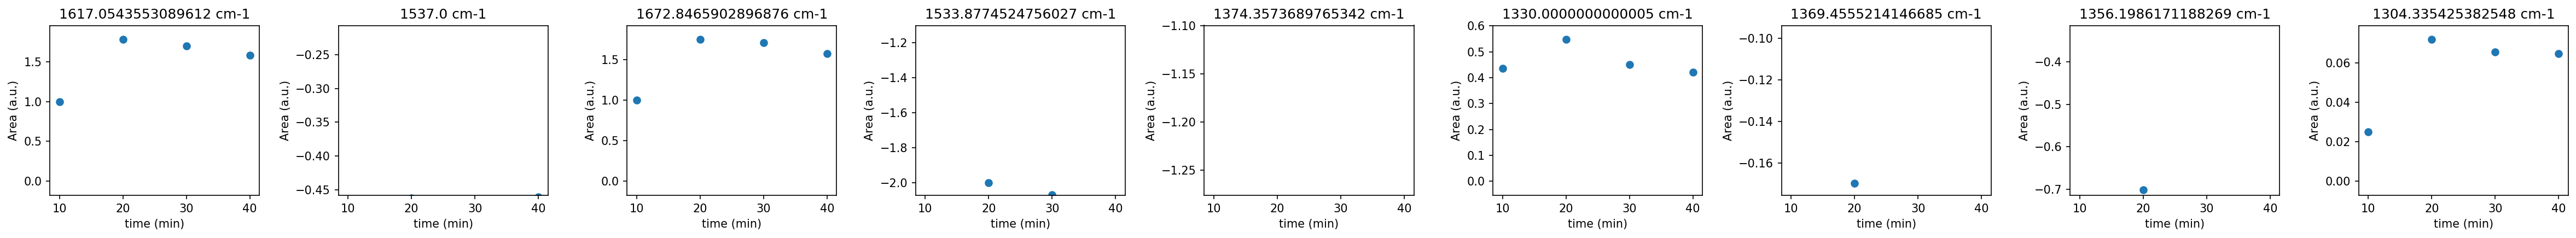

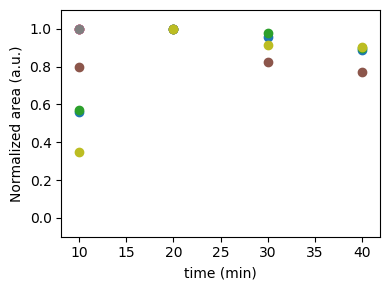

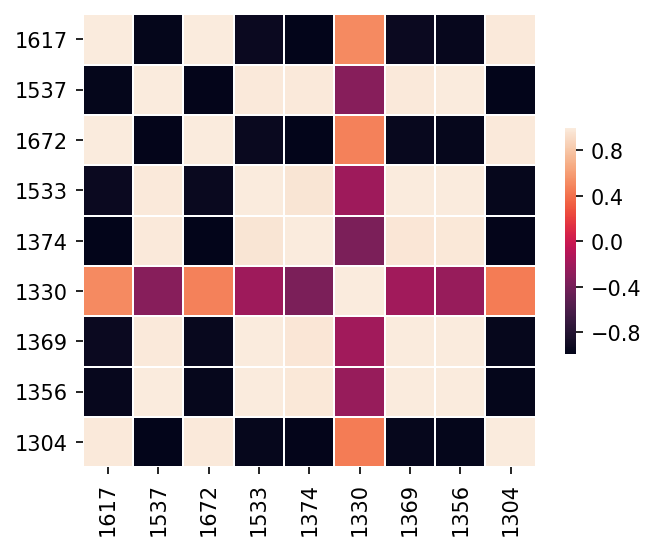

{'Peak Pos': [1617, 1537, 1672, 1533, 1374, 1330, 1369, 1356, 1304],
 'Amps': array([[ 1.        , -0.18766928,  1.        , -1.        , -1.        ,
          0.43608195, -0.08534017, -0.28560989,  0.02496124],
        [ 1.77758477, -0.4625658 ,  1.74642761, -2.        , -1.3447045 ,
          0.54674261, -0.16979584, -0.70101156,  0.0717574 ],
        [ 1.696622  , -0.47733322,  1.70765974, -2.0682562 , -1.37614362,
          0.44949739, -0.18084265, -0.74280849,  0.06561122],
        [ 1.57796152, -0.46120526,  1.57365035, -2.17216037, -1.30447473,
          0.4212215 , -0.18419162, -0.73820754,  0.06474271]])}

In [59]:
params_IG1 = result.params
Plot_data_IG(params_IG1,x_CC,y_CC[nstart:nstart+ndata],Vec_CC_IG1,time_CH[nstart:nstart+ndata],True)

In [49]:
Vec_fit_CC1 = Generate_Vec_IG(params_IG,Vec_IG_CC0,ndata)

In [60]:
t0 = time.time()
Vec_fit_CC1['Alphas'] = None
Vec_fit_CC1['Vec1']['Mus'][1] = 1540.
Vec_fit_CC1['Vec1']['Lims'] = {'Peaks':np.array([0,1]),'Specs':np.array([[1500,1480],[1580,1585],[0.1,0.1],[10,25],[-10,-10]]),'Pos':None}
Vec_fit_CC1['Vec3']['Lims'] = {'Peaks':np.array([0,1]),'Specs':np.array([[1355,1355],[1370,1370],[1.2,1.2],[3.5,4],[-10,-10]]),'Pos':None}
fit_params_CC1 = Generate_params(x_CC,Vec_fit_CC1,ndata =ndata)
fitter = Minimizer(loss_func, fit_params_CC1, fcn_args=(x_CC, y_CC[nstart:nstart+ndata], Vec_fit_CC1))
result = fitter.minimize(method='leastsq')
t1 = time.time() 

print('The time cost is:',t1-t0)

0 12.42242865476835 0.1 27.42242865476835
0 1590.0 1560.0 1620.0
1 3.624 0.1 6.5
1 1537.3187234594832 1532.3187234594832 1542.3187234594832
1 17.8 2.8000000000000007 25.0
1 1540.0 1510.0 1570.0
2 9.381088170905238 0.1 24.381088170905237
2 1535.825970555125 1505.825970555125 1565.825970555125
2 21.049445606838308 6.049445606838308 36.049445606838304
2 1468.533937853286 1438.533937853286 1498.533937853286
2 16.030000000000292 1.0300000000002925 31.030000000000292
2 1391.2734243358188 1361.2734243358188 1421.2734243358188
3 2.293199999996125 1.2 3.5
3 1369.4087684852152 1364.4087684852152 1370.0
3 5.687499999999439 1.2 4.0
3 1356.6860000570964 1355.0 1361.6860000570964
4 1.400000000000001 0.1 6.400000000000001
4 1305.9041773330187 1300.9041773330187 1310.9041773330187
The time cost is: 22.371062994003296


The score of the fit is: 0.0035119752068760546
Plotting.....


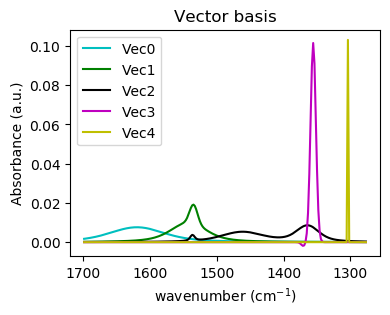

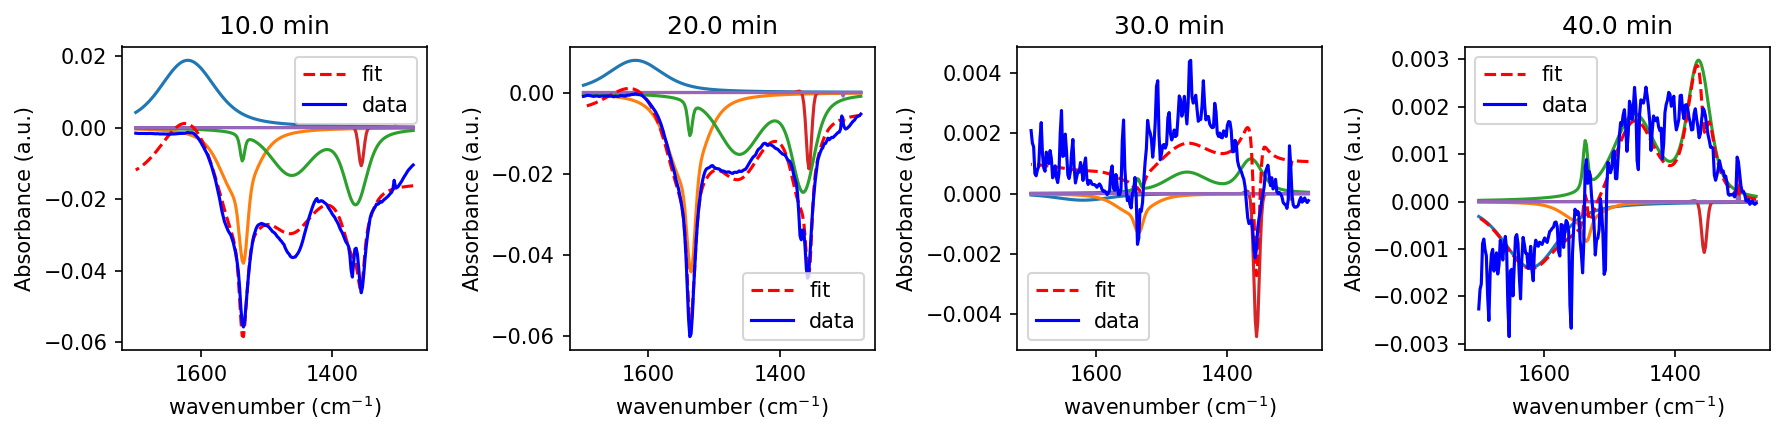

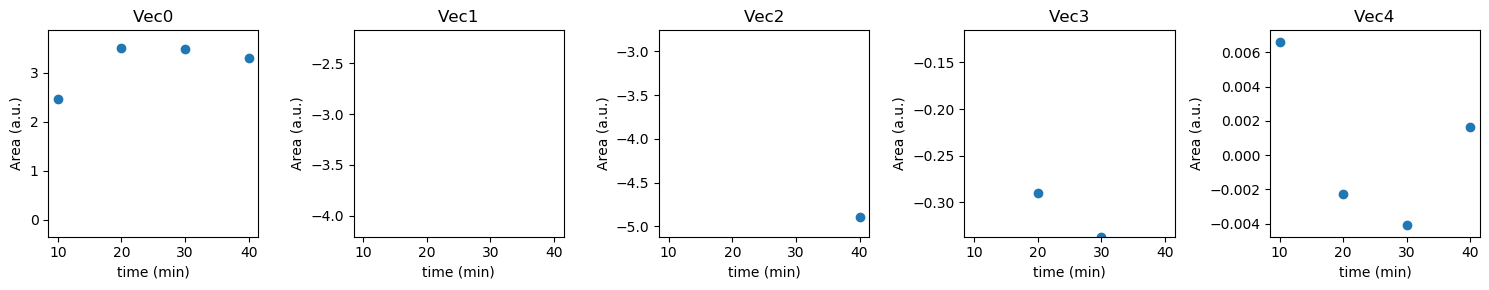

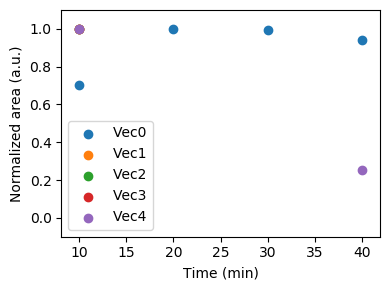

In [61]:
new_params1 = result.params
print('The score of the fit is:', result.chisqr)
Plot_data(new_params1,x_CC,y_CC[nstart:nstart+ndata],Vec_fit_CC1,time_CH[nstart:nstart+ndata],True)

### Fitting the Final Stage (180,720) min

We use postfix _CC2 for fitting of this period.

Below is an intial guess of the peaks.

In [83]:
Vec_IG_CC2 = {'Mus':np.array([1600, 1537.8, 1541.7, 1473.6, 1386, 1352, 1369.1, 1357.9, 1303.9]),
             'Sigmas':np.array([15.9, 4.4,18.7, 20, 18, 8.7, 2.4, 4, 2.37]),
             'Types':np.array([0,1,0,0,0,0,1,1,1]),
             'Fixed':None,#np.array([0,0,0,0,0,0,0,1,1,1]),
             'Lims':{'Positive':False,
                     'Mus_min':np.array([1595,1537., 1500., 1460, 1370,1330, 1300, 1330, 1300.])}
             }


In [84]:
t0 = time.time()
nstart = 10
ndata = 9
fit_params_IG2 = Generate_params_IG(x_CC,Vec_IG_CC2,ndata = ndata)
fitter = Minimizer(loss_func_IG, fit_params_IG2, fcn_args=(x_CC, y_CC[nstart:nstart+ndata], Vec_IG_CC2))
result = fitter.minimize(method='leastsq')
t1 = time.time() 

print('The time cost is:',t1-t0)

The time cost is: 310.9507749080658


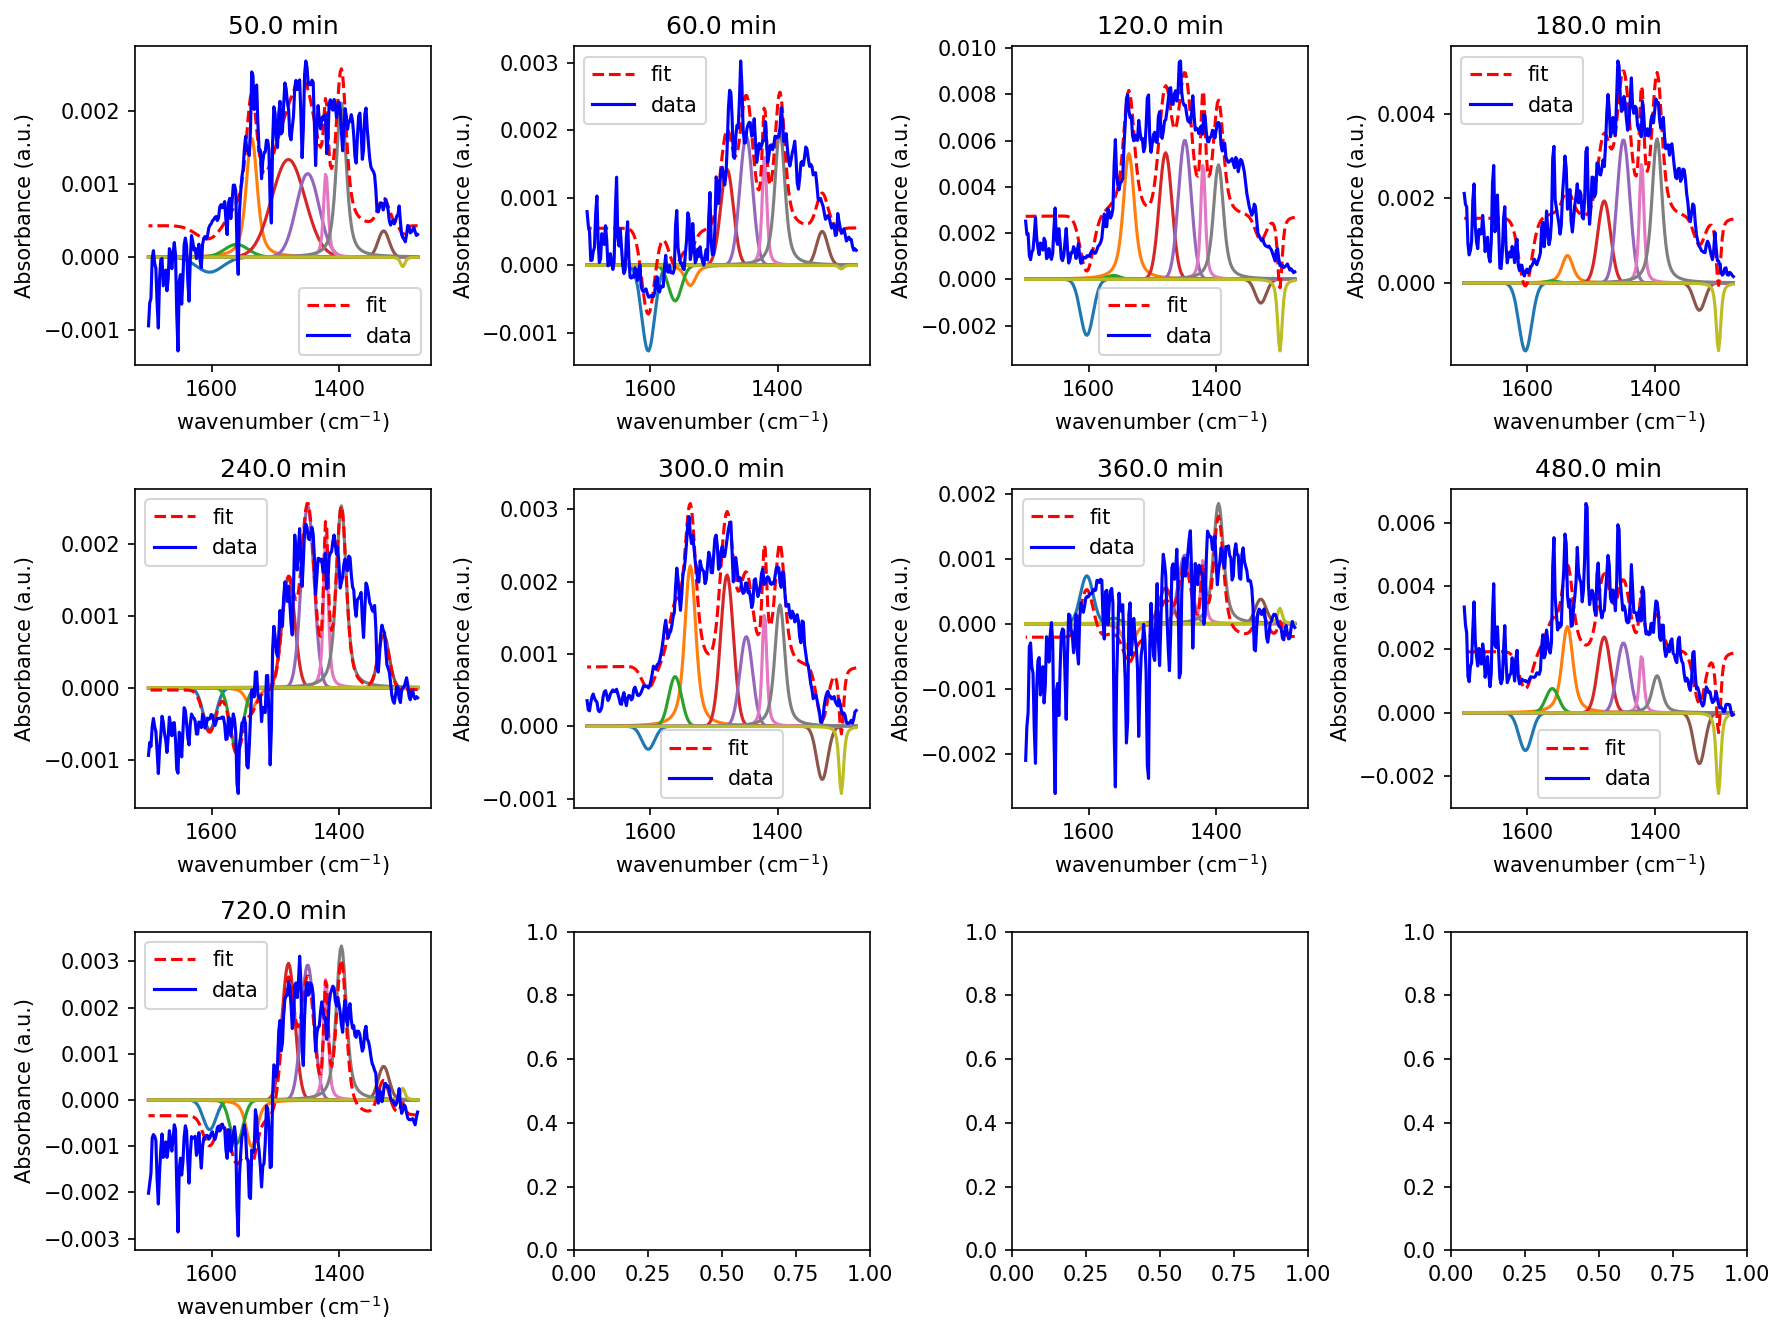

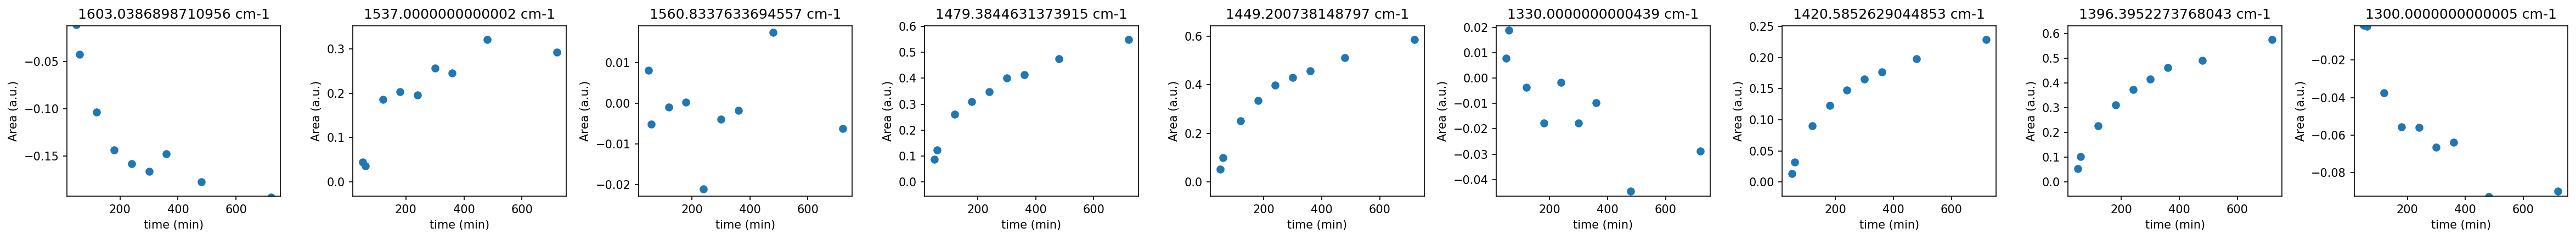

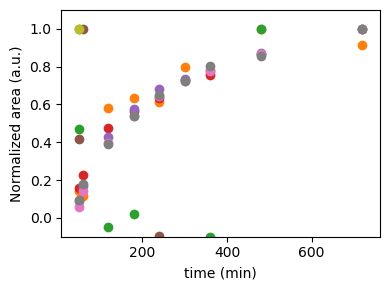

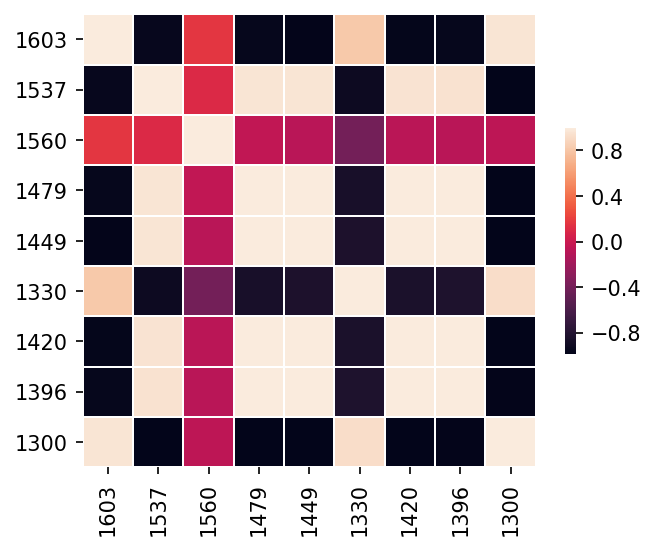

{'Peak Pos': [1603, 1537, 1560, 1479, 1449, 1330, 1420, 1396, 1300],
 'Amps': array([[-1.06821457e-02,  4.46721980e-02,  8.17606910e-03,
          8.72900091e-02,  5.17118940e-02,  7.86247649e-03,
          1.33306688e-02,  5.26850875e-02, -1.49051818e-03],
        [-4.25815649e-02,  3.64631535e-02, -5.08445827e-03,
          1.23017618e-01,  9.97306453e-02,  1.88472923e-02,
          3.21011370e-02,  1.02411669e-01, -2.10715610e-03],
        [-1.03382520e-01,  1.85467058e-01, -8.81212115e-04,
          2.60268052e-01,  2.50762145e-01, -3.64826437e-03,
          8.99071105e-02,  2.25731101e-01, -3.73786262e-02],
        [-1.43729208e-01,  2.03341522e-01,  3.25391022e-04,
          3.08979587e-01,  3.35834023e-01, -1.77397906e-02,
          1.22803518e-01,  3.10710272e-01, -5.55664705e-02],
        [-1.58417617e-01,  1.95610299e-01, -2.11622857e-02,
          3.47513673e-01,  3.99114284e-01, -1.78812371e-03,
          1.47509616e-01,  3.73619557e-01, -5.58233834e-02],
        [-1.663570

In [85]:
params_IG2 = result.params
Plot_data_IG(params_IG2,x_CC,y_CC[nstart:nstart+ndata],Vec_IG_CC2,time_CH[nstart:nstart+ndata],True)

In [89]:
Vec_fit_CC2 = Generate_Vec_IG(params_IG2,Vec_IG_CC0,ndata)

In [90]:
t0 = time.time()

Vec_fit_CC2['Alphas'] = None
#Vec_fit_CC2['Vec0']['Lims'] = {'Peaks':np.array([0]),'Specs':np.array([[0],[1610],[10],[20],[0]]),'Pos':None}
Vec_fit_CC2['Vec1']['Lims'] = {'Peaks':np.array([0,1]),'Specs':np.array([[1500,1410],[1700,1580],[1.2,0.1],[7.5,25],[0,0]]),'Pos':None}
Vec_fit_CC2['Vec2']['Lims'] = {'Peaks':np.array([0,1,2]),'Specs':np.array([[0,0,0],[4000,4000,4000],[0.1,0.1,0.1],[25,25,25],[0,0,0]]),'Pos':None}
Vec_fit_CC2['Vec3']['Lims'] = {'Peaks':np.array([0,1]),'Specs':np.array([[1355,1355],[1370,1370],[0.1,0.1],[5,5],[-0,0]]),'Pos':None}

fit_params_CC2 = Generate_params(x_CC,Vec_fit_CC2,ndata=ndata)

fitter = Minimizer(loss_func, fit_params_CC2, fcn_args=(x_CC, y_CC[nstart:nstart+ndata], Vec_fit_CC0))
result = fitter.minimize(method='leastsq')
t1 = time.time() 

print('The time cost is:',t1-t0)

0 20.669999999999998 5.669999999999998 35.67
0 1603.0386898710956 1573.0386898710956 1633.0386898710956
1 5.720000000000001 1.2 6.5
1 1537.0000000000002 1532.0000000000002 1542.0000000000002
1 18.7 3.6999999999999993 25.0
1 1560.8337633694557 1530.8337633694557 1580.0
2 25.99999999999999 10.99999999999999 25.0
2 1479.3844631373915 1449.3844631373915 1509.3844631373915
2 18.0 3.0 25.0
2 1449.200738148797 1419.200738148797 1479.200738148797
2 8.7 0.1 23.7
2 1330.0000000000439 1300.0000000000439 1360.0000000000439
3 2.4 0.1 5.0
3 1420.5852629044853 1415.5852629044853 1370.0
3 5.199999825788961 0.1999998257889608 5.0
3 1396.3952273768043 1391.3952273768043 1370.0
4 2.37 0.1 7.37
4 1300.0000000000005 1295.0000000000005 1305.0000000000005
The time cost is: 28.386316061019897


The score of the fit is: 4.7598756026970985e-07
Plotting.....


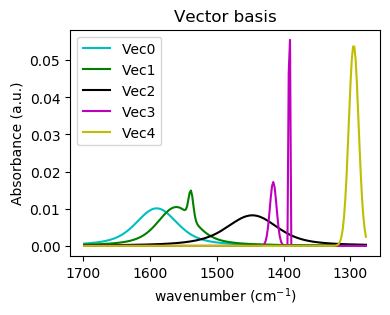

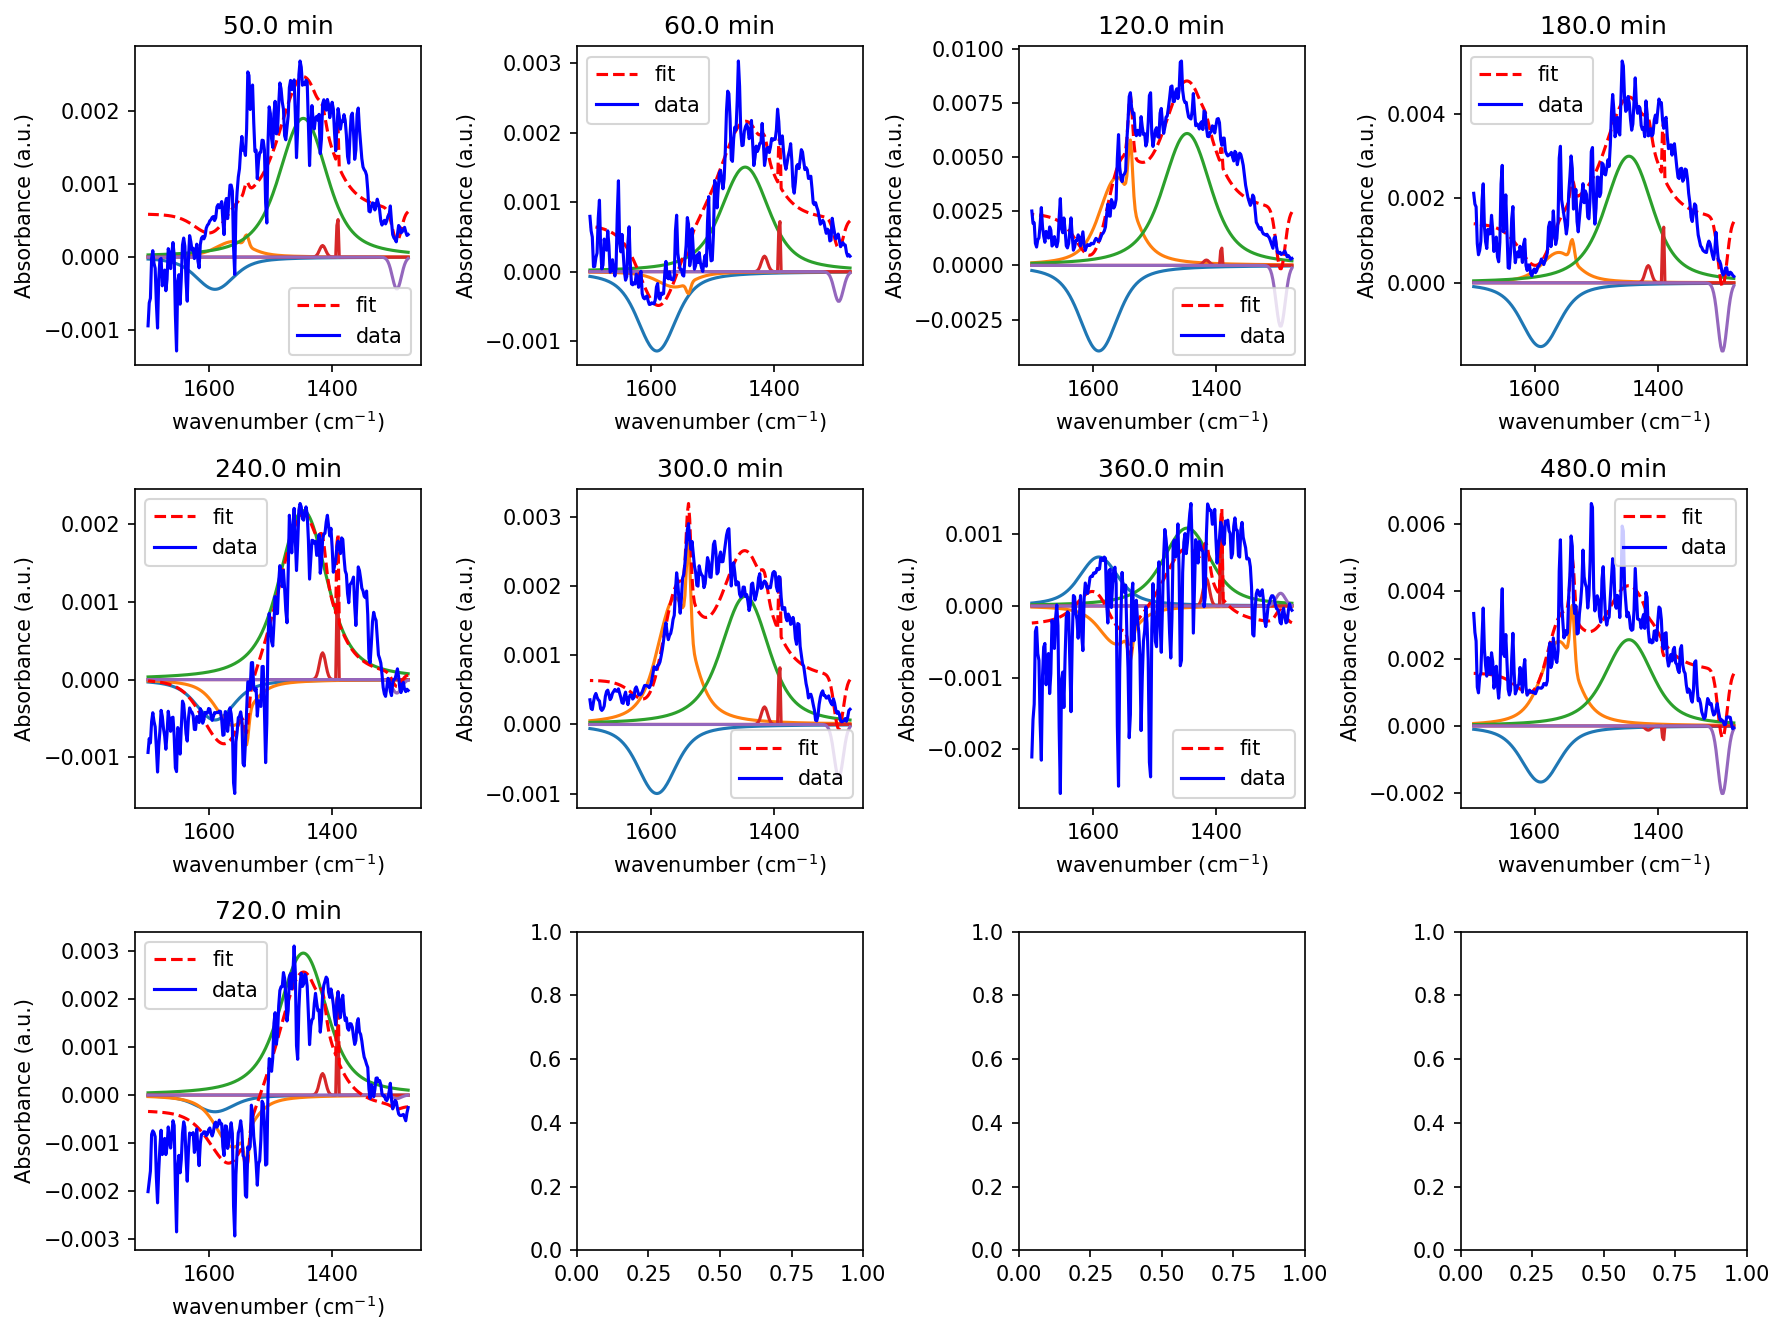

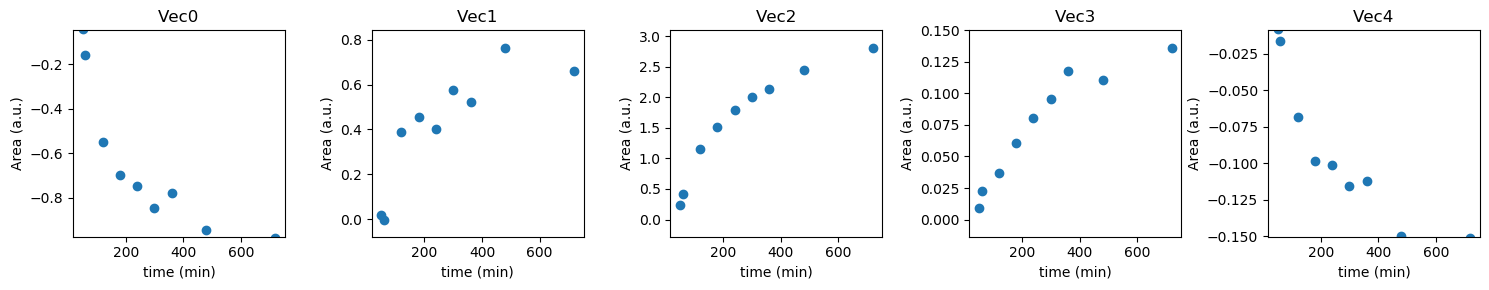

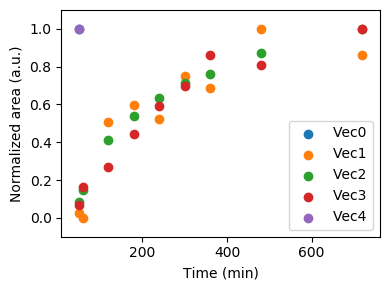

In [91]:
new_params2 = result.params
print('The score of the fit is:', result.redchi)
Plot_data(new_params2,x_CC,y_CC[nstart:nstart+ndata],Vec_fit_CC2,time_CH[nstart:nstart+ndata],True)

In [95]:
report_fit(new_params2)

[[Variables]]
    lin_0:    0.00899255 +/- 8.0514e-04 (8.95%) (init = 0)
    amp_000: -2.06612066 +/- 0.21142055 (10.23%) (init = -0.0159953)
    cen_000:  1658.62214 +/- 2.40447866 (0.14%) (init = 1660.566)
    sig_000:  35.6395247 +/- 2.39828979 (6.73%) (init = 20.67)
    amp_010: -0.03498127 +/- 0.01063197 (30.39%) (init = 0.01738673)
    cen_010:  1544.66922 +/- 0.50777425 (0.03%) (init = 1538.199)
    sig_010:  3.46331282 +/- 0.52060401 (15.03%) (init = 5.72)
    amp_011: -0.04149741 +/- 0.06916150 (166.66%) (init = 0.02865532)
    cen_011:  1414.53014 +/- 27.3117207 (1.93%) (init = 1520)
    sig_011:  24.9664492 +/- 29.1180869 (116.63%) (init = 18.7)
    amp_020:  1.37376784 +/- 0.22926757 (16.69%) (init = 0.03299403)
    cen_020:  1493.48739 +/- 1.24377840 (0.08%) (init = 1463.6)
    sig_020:  14.7579350 +/- 1.19318918 (8.09%) (init = 17.12901)
    amp_021:  3.37342528 +/- 0.50022979 (14.83%) (init = 0.02176485)
    cen_021:  1424.42012 +/- 3.87924132 (0.27%) (init = 1407.2)
   

array([[ 8.11418928e-01,  1.98754636e+00,  2.53912816e+00,
         2.97423553e+00,  3.66190162e+00,  3.79956185e+00,
         6.26722394e+00,  7.30976791e+00,  7.28081651e+00,
         7.09815456e+00,  7.05437823e+00,  6.94134080e+00,
         6.54962716e+00,  6.40016057e+00,  6.34856697e+00,
         6.24991290e+00,  6.31750474e+00,  6.15237933e+00,
         6.11780431e+00],
       [ 8.64511219e-01,  2.23438085e+00,  2.84447122e+00,
         3.27400997e+00,  3.93698558e+00,  4.18923371e+00,
         2.20956968e+00, -1.01172859e-01, -1.69564217e-01,
        -2.13479510e-01, -1.93038405e-01, -2.14135815e-01,
         1.74496660e-01,  2.43341854e-01,  1.86879999e-01,
         3.61887651e-01,  3.10860497e-01,  5.51327374e-01,
         4.47294144e-01],
       [ 3.97511808e+00,  7.52901828e+00,  1.11796720e+01,
         1.50834361e+01,  2.41145219e+01,  2.72905141e+01,
         2.47829459e+01,  2.19224831e+01,  2.20563365e+01,
         2.24030559e+01,  2.26346552e+01,  2.28175943e+01,
    

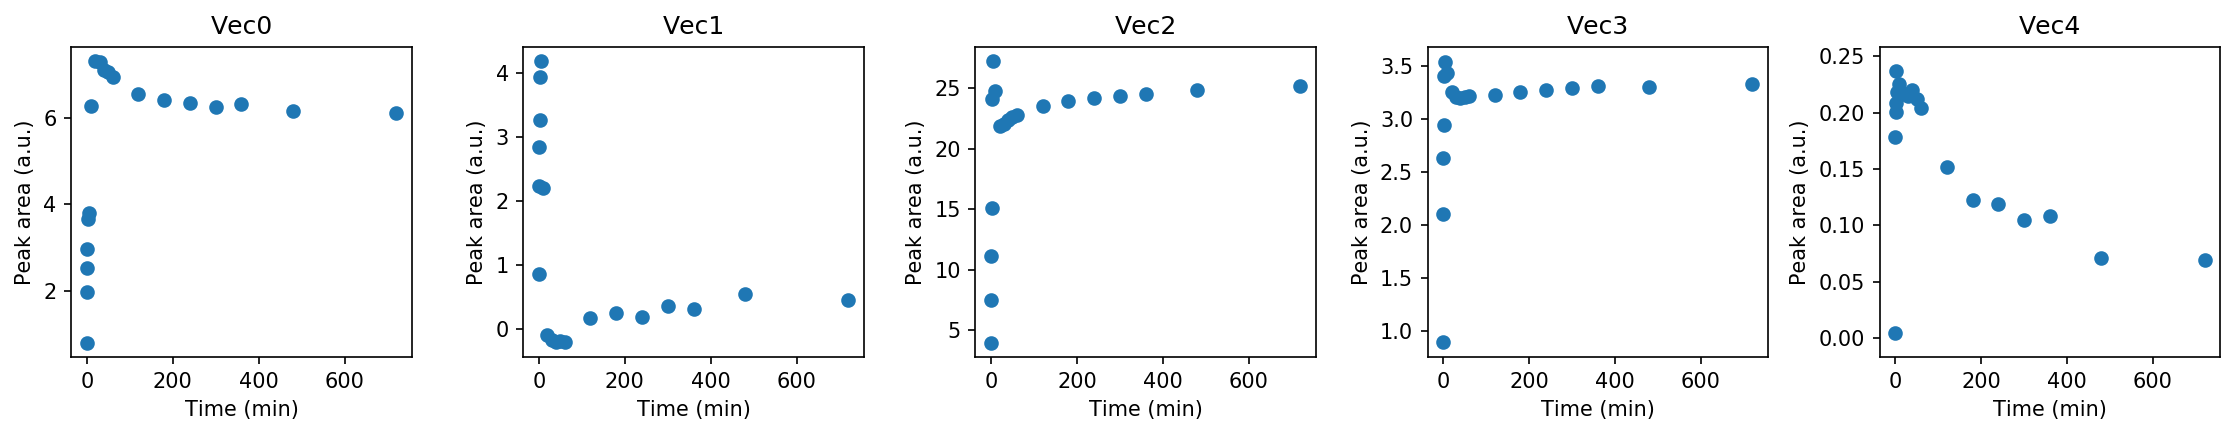

In [94]:
Param_com = {'Params': (new_params0,new_params1,new_params2) ,
            'Lens':np.array([6,4,9])}
Plot_com_data(Param_com,Vec_IG_CC0,Time[:19],True)

## Fitting the 1000 - 1300 cm$^{-1}$ region

This region contains charistic peaks from C-O speices. 

In [99]:
Vec_IG_CO = {'Mus':np.array([1215, 1055, 1112.2]),
          'Sigmas':np.array([15.3,13.6,15.3]),
          'Types':np.array([1,1,1]),
          'Fixed':None,
          'Lims':None}


In [100]:
t0 = time.time()
fit_params_IG_CO = Generate_params_IG(x_CO,Vec_IG_CO,ndata =19)

fitter = Minimizer(loss_func_IG, fit_params_IG_CO, fcn_args=(x_CO, y_CO, Vec_IG_CO))
result = fitter.minimize(method='leastsq')
t1 = time.time() 

print('The time cost is:',t1-t0)

The time cost is: 16.148460865020752


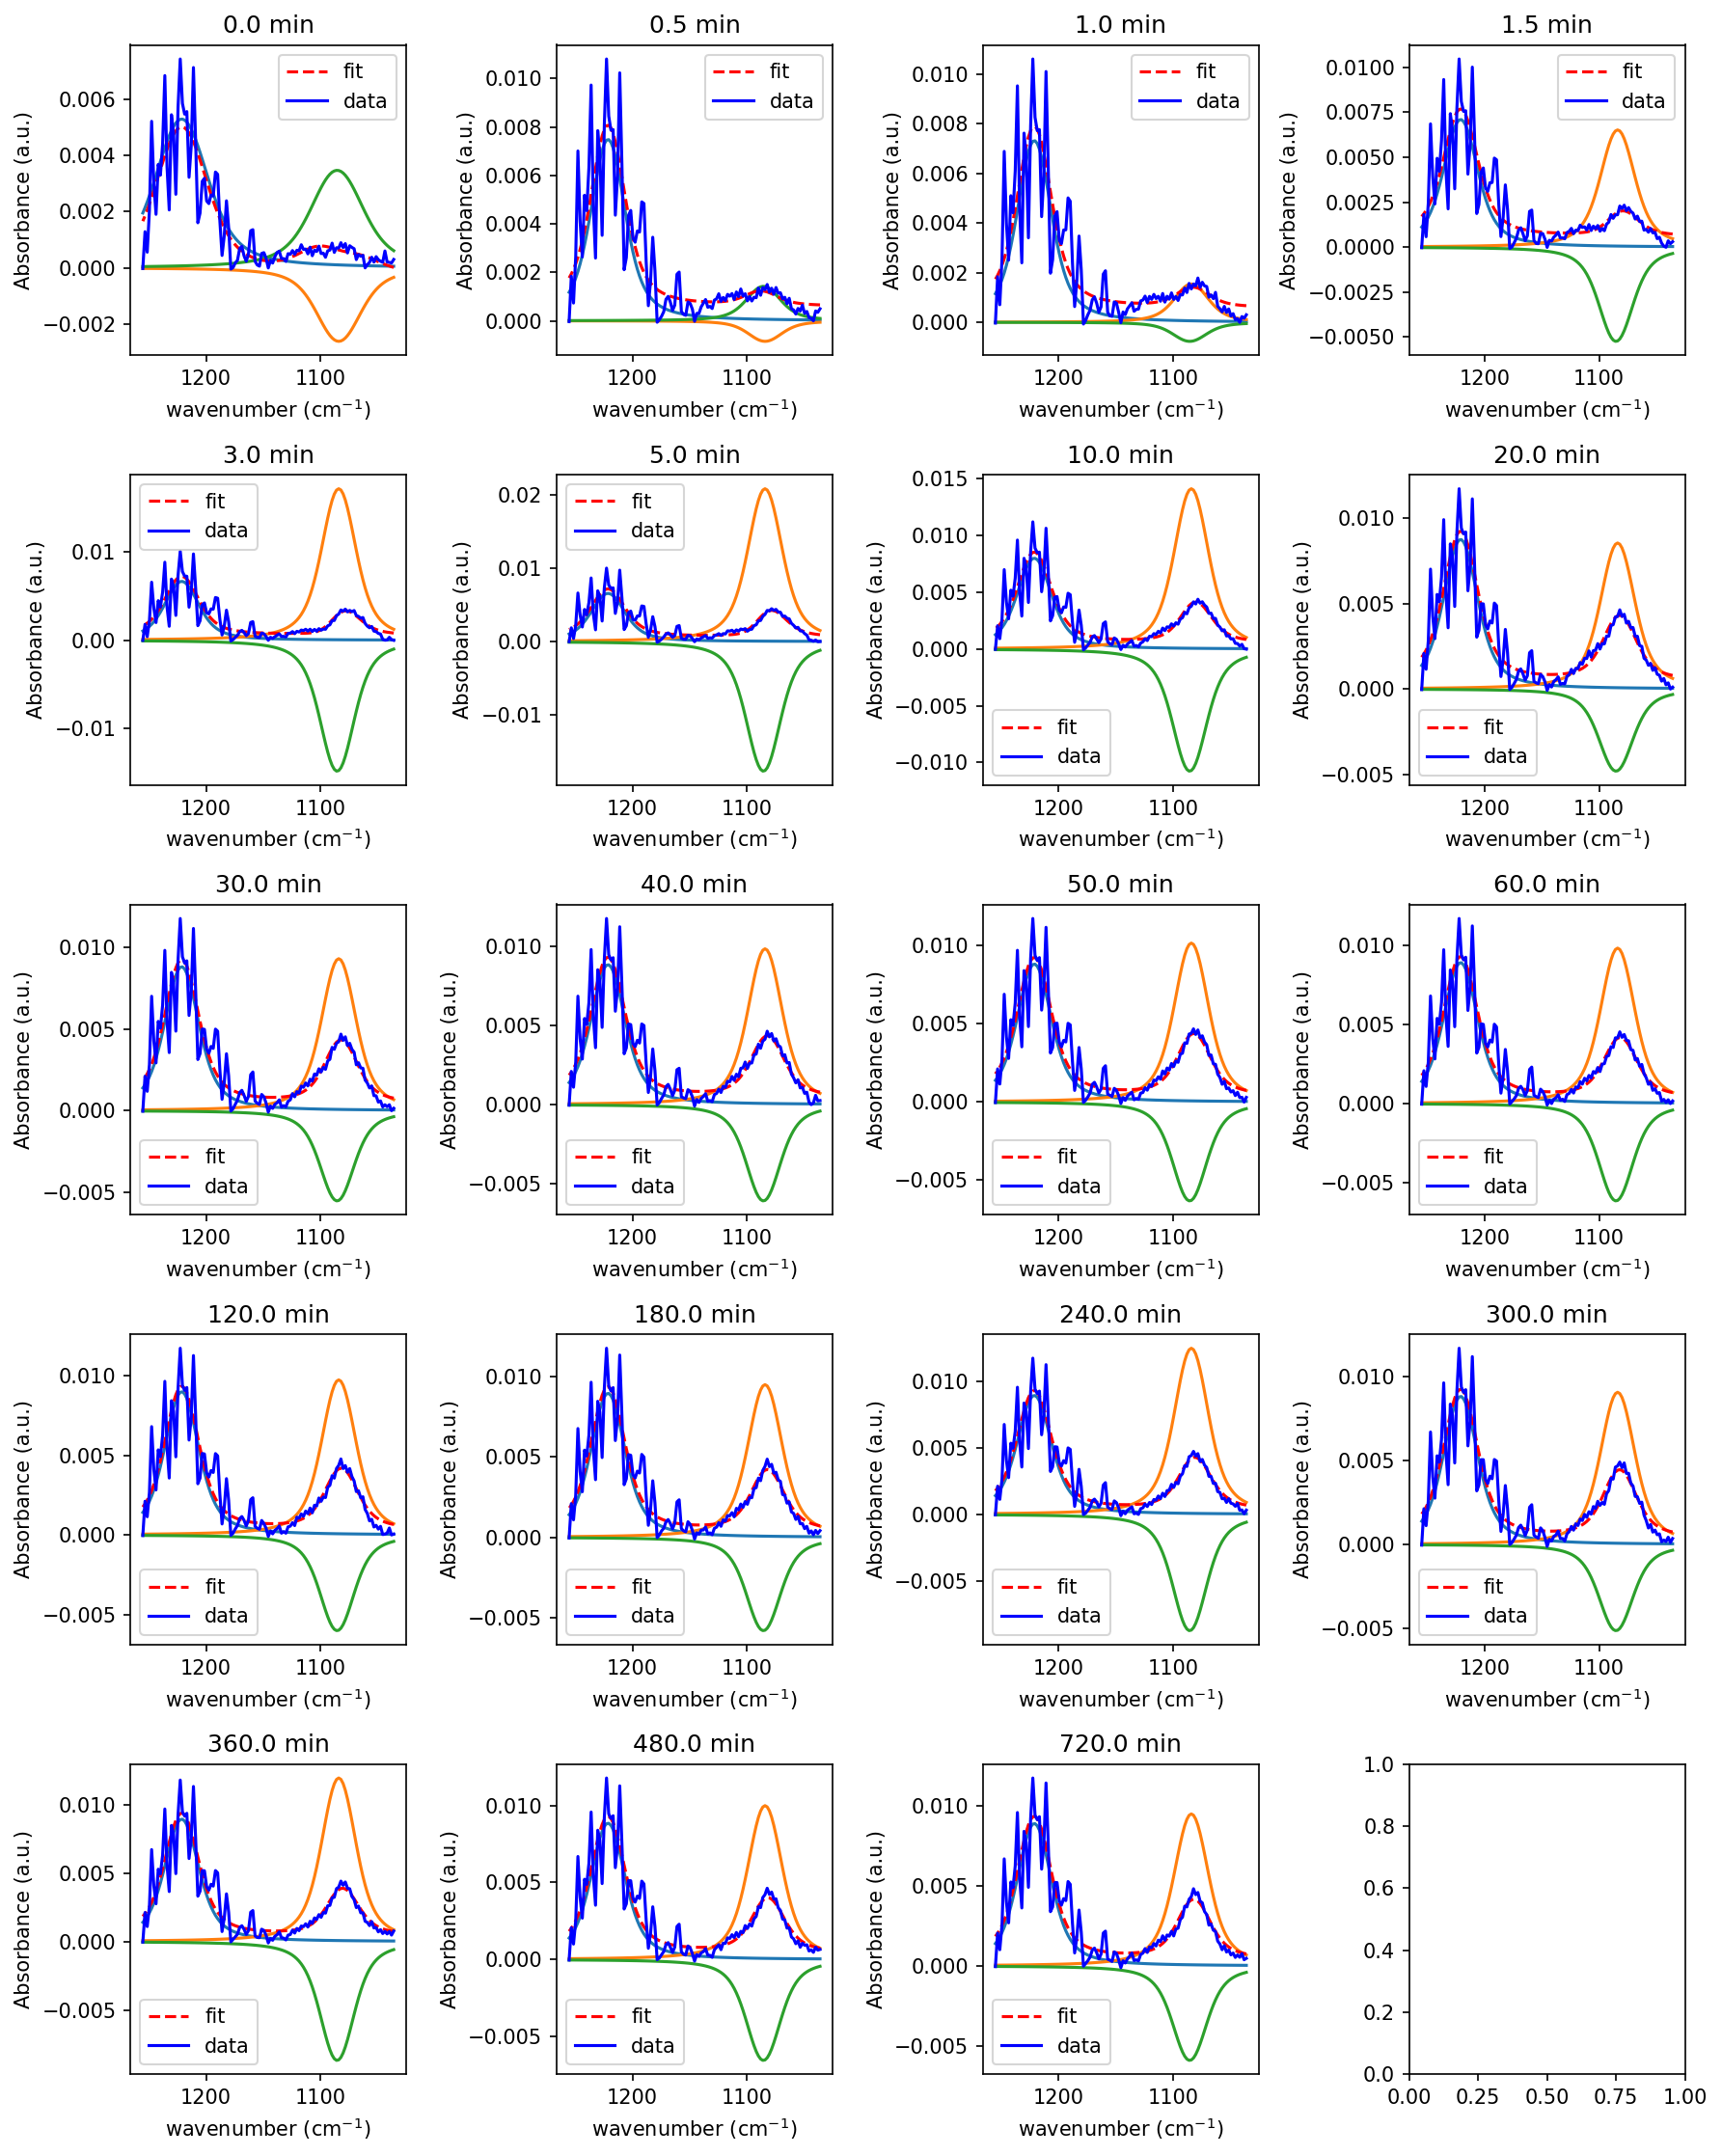

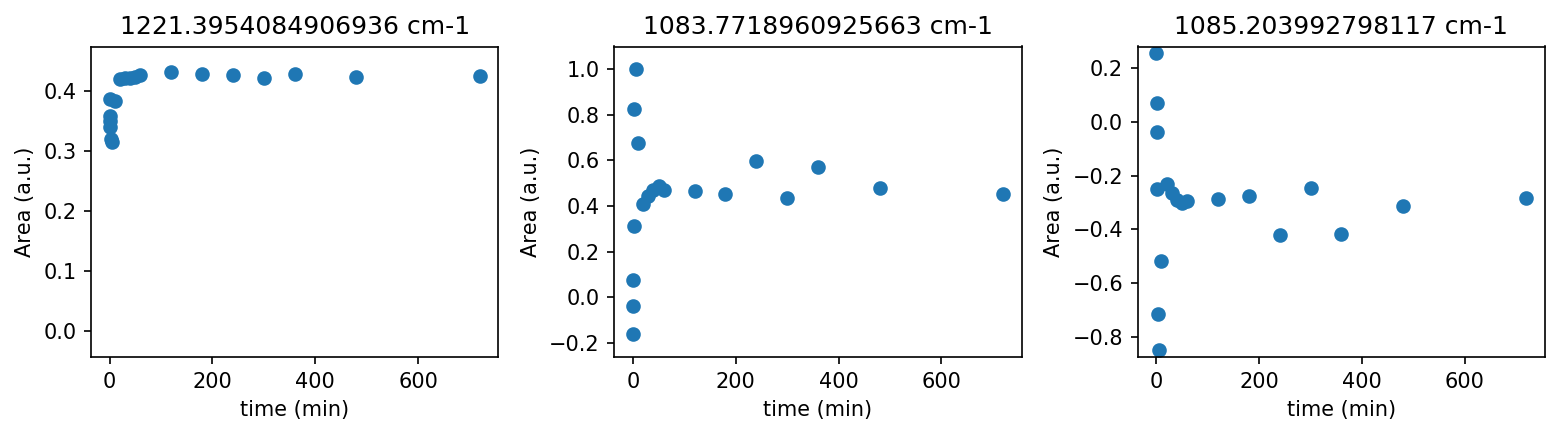

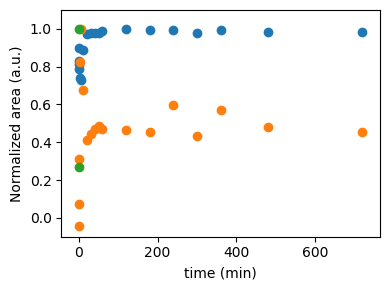

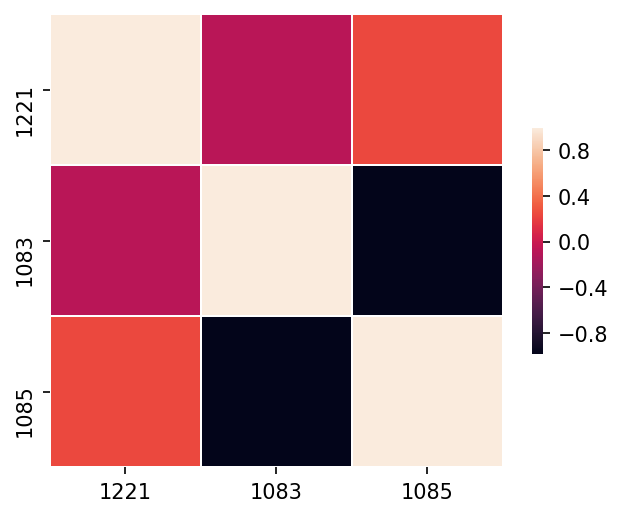

{'Peak Pos': [1221, 1083, 1085],
 'Amps': array([[ 0.38758466, -0.16284333,  0.25394906],
        [ 0.35855976, -0.04070506,  0.06807722],
        [ 0.35105549,  0.07402639, -0.03687027],
        [ 0.34011195,  0.31224288, -0.2512327 ],
        [ 0.32016876,  0.82445162, -0.71274934],
        [ 0.31491347,  0.99999968, -0.84832526],
        [ 0.38362474,  0.67729469, -0.51618848],
        [ 0.41998086,  0.41002095, -0.23100507],
        [ 0.42247623,  0.44599348, -0.2651955 ],
        [ 0.42235878,  0.47029421, -0.29089257],
        [ 0.42290917,  0.4871737 , -0.30323148],
        [ 0.42713093,  0.47104146, -0.29510744],
        [ 0.43132641,  0.46701503, -0.28840916],
        [ 0.42840482,  0.45419272, -0.27747542],
        [ 0.42767405,  0.59760961, -0.41862566],
        [ 0.42249115,  0.43424459, -0.24596449],
        [ 0.42792373,  0.57175232, -0.41555111],
        [ 0.42374911,  0.47831918, -0.31387314],
        [ 0.42508356,  0.45369704, -0.28189307]])}

In [101]:
params_IG_CO = result.params
Plot_data_IG(params_IG_CO,x_CO,y_CO,Vec_IG_CO,time_CH[:19],False)

In [105]:
Vec_IG_struc_CO = {'Peaks':[[0,2],[1]],'Types':[[0,1],[1]]}
Vec_fit_CO = Generate_Vec_IG(params_IG_CO,Vec_IG_struc_CO,19)
#Vec_fit['Vec0']['Lims'] = {'Peaks':np.array([0,1,2,3]),
 #                          'Specs':np.array([[0.1,0.1,0.1,0.1],
 #                                           [4000,4000,4000,4000],
 #                                           [0.1,.1,0.1,0.1],
  #                                          [6.5,6.5,6.5,6.5]])}


In [106]:
t0 = time.time()
fit_params_CO = Generate_params(x_CO,Vec_fit_CO,ndata = 19)

fitter = Minimizer(loss_func, fit_params_CO, fcn_args=(x_CO, y_CO, Vec_fit_CO))
result = fitter.minimize(method='leastsq')
t1 = time.time()

print('The time cost is:',t1-t0)

0 15.3 10.3 20.3
0 1221.3954084906936 1216.3954084906936 1226.3954084906936
0 15.3 0.3000000000000007 30.3
0 1085.203992798117 1055.203992798117 1115.203992798117
1 12.994125269831775 0.1 27.994125269831777
1 1083.7718960925663 1053.7718960925663 1113.7718960925663
The time cost is: 9.379240989685059


In [107]:
new_params_CO = result.params
report_fit(new_params_CO)

[[Variables]]
    lin_0:     4.2919e-04 +/- 1.7505e-04 (40.79%) (init = 0)
    amp_000:   0.23074722 +/- 0.01752827 (7.60%) (init = 0.2551794)
    cen_000:   1221.09283 +/- 0.23495111 (0.02%) (init = 1221.395)
    sig_000:   19.3770599 +/- 0.30779604 (1.59%) (init = 15.3)
    amp_001:   0.02466018 +/- 0.01438338 (58.33%) (init = -0.1914662)
    cen_001:   1077.26031 +/- 1.55365862 (0.14%) (init = 1085.204)
    sig_001:   5.59540403 +/- 1.45839731 (26.06%) (init = 15.3)
    amp_010:  -0.01891335 +/- 0.02782268 (147.11%) (init = -0.0722152)
    cen_010:   1084.06721 +/- 1.60852943 (0.15%) (init = 1083.772)
    sig_010:   11.3515519 +/- 1.18634525 (10.45%) (init = 12.99413)
    lin_1:     6.1875e-04 +/- 1.7678e-04 (28.57%) (init = 0)
    amp_100:   0.32479994 +/- 0.01781109 (5.48%) (init = 0.1697011)
    cen_100:   1221.09283 +/- 0.23495111 (0.02%) == 'cen_000'
    sig_100:   19.3770599 +/- 0.30779604 (1.59%) == 'sig_000'
    amp_101:   0.03471168 +/- 0.02019085 (58.17%) == 'amp_100*amp_0

Plotting.....


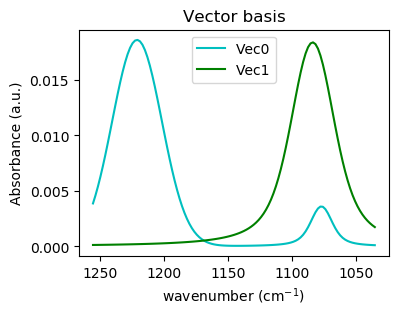

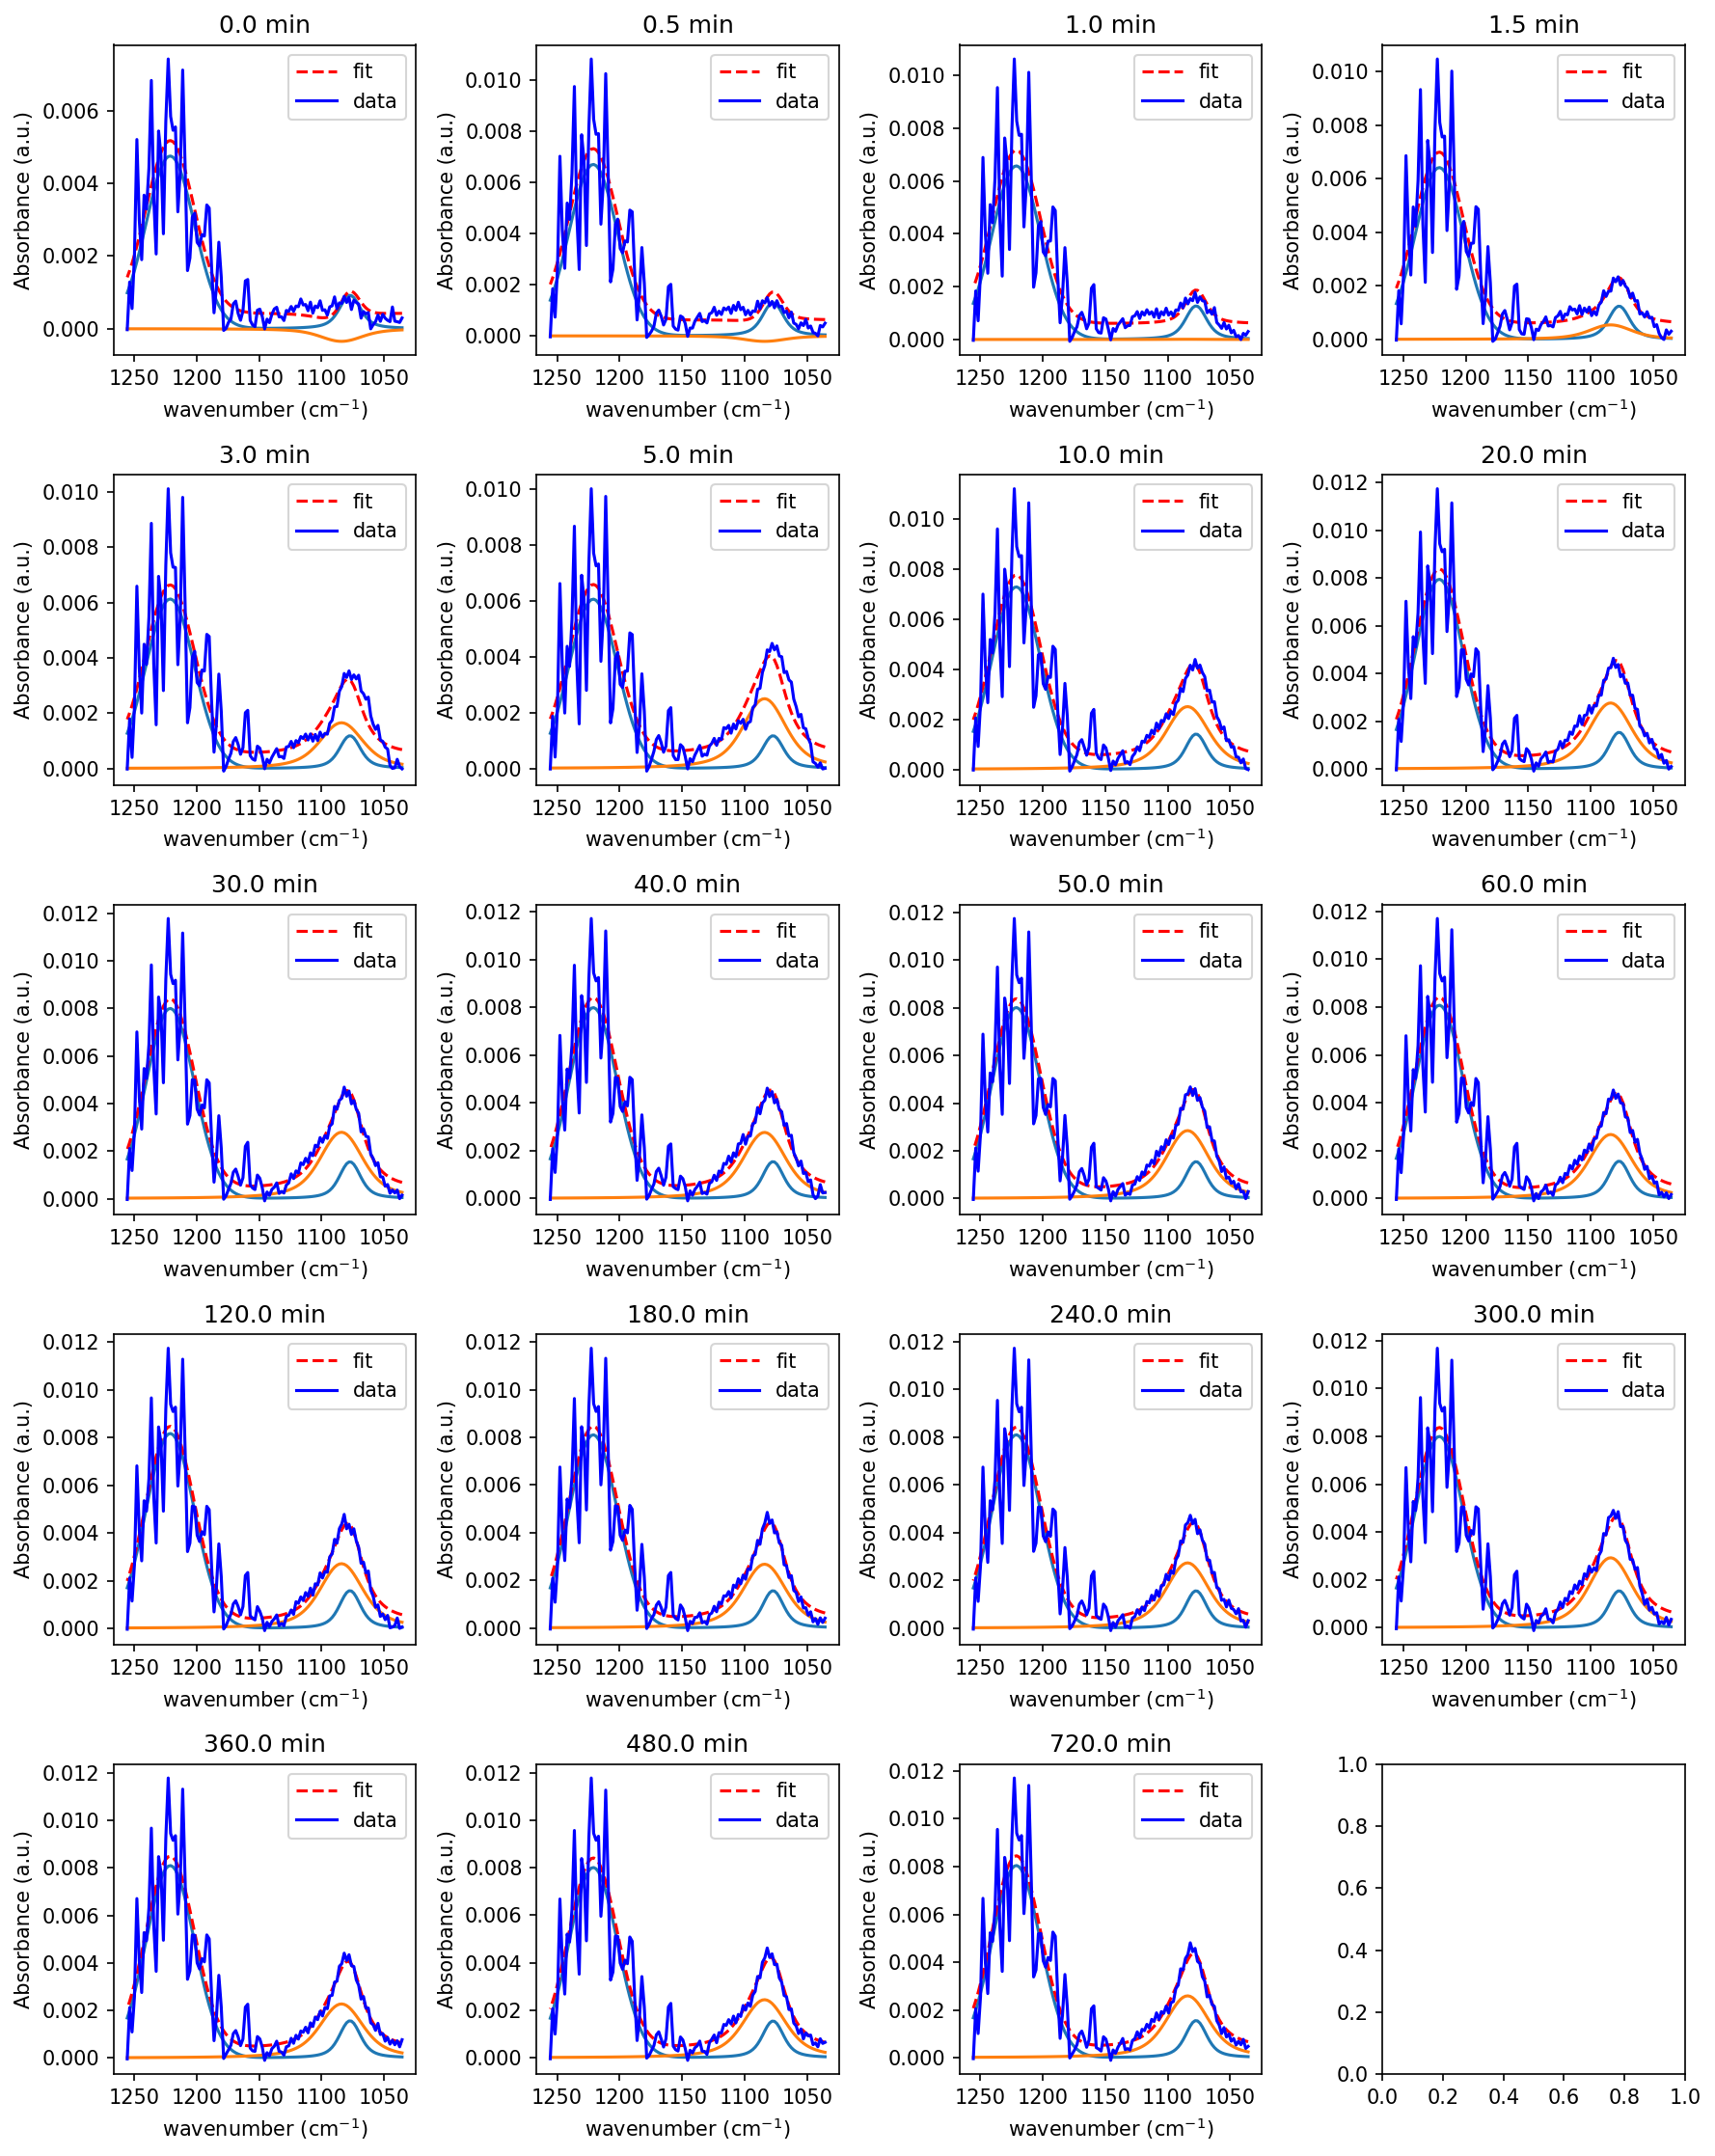

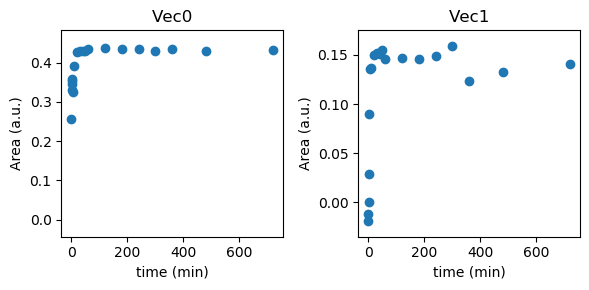

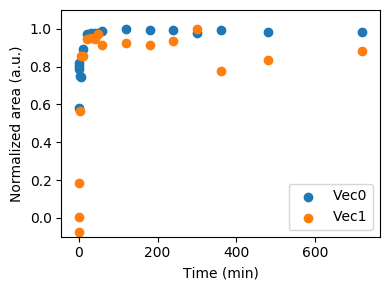

In [108]:
Plot_data(new_params_CO,x_CO,y_CO,Vec_fit_CO,time_CH[:19],False)

In [109]:
def Print_var(Param,Name,Vec,Assignment=None):
    print('Species\t\tType\t\tPeak (cm-1)\terror(%)\tVariance (cm-1)\terror(%)')
    nVec = len(Name)
    data = np.zeros((nVec,len(Time)))
    for j in range(nVec):
        print(Name[j], end='\t')
        nPeak = len(Vec['Peaks'][j])
        for k in range(nPeak):
            if k != 0:
                print('\t',end='\t')
            if Vec['Types'][j][k]:
                print('Voigt', end='\t\t')
            else:
                print('Gaussian', end='\t')
            mu = Param['cen_{}{}{}'.format(0,j,k)].value
            muerror = Param['cen_{}{}{}'.format(0,j,k)].stderr
            sigma = Param['sig_{}{}{}'.format(0,j,k)].value
            sigmaerror = Param['sig_{}{}{}'.format(0,j,k)].stderr
            print('{:.1f}\t\t{}\t\t{:.1f}\t\t{}'.format(mu,muerror,sigma,sigmaerror))
    return None

In [110]:
Vec_IG_struc = {'Peaks':np.array([[0,1,2,3]]),'Types':np.array([[1,1,1,1 ]])}
Print_var(new_params,np.array(['Formates']),Vec_IG_struc)


Species		Type		Peak (cm-1)	error(%)	Variance (cm-1)	error(%)
Formates	Voigt		2878.9		1.544458415460879		6.5		0.36283613303395046
		Voigt		2955.7		0.2565719570557516		4.4		0.21300785746794118
		Voigt		2856.2		0.23818080703325953		6.5		0.15007414522079834
		Voigt		2931.8		0.08178043513231978		4.8		0.06822376201640355


In [111]:
for i in range(3):
    Print_var(Param_com['Params'][i],np.array(['Carbonyls','Carbonates','Aromatics','Formates','Gas CH4\t']),Vec_IG_CC0)

Species		Type		Peak (cm-1)	error(%)	Variance (cm-1)	error(%)
Carbonyls	Voigt		1560.0		None		9.4		None
Carbonates	Gaussian	1536.9		None		7.5		None
		Voigt		1673.5		None		17.8		None
Aromatics	Voigt		1520.3		None		8.4		None
		Voigt		1475.3		None		21.0		None
		Voigt		1382.8		None		31.0		None
Formates	Gaussian	1369.6		None		1.3		None
		Gaussian	1359.5		None		10.7		None
Gas CH4		Gaussian	1300.9		None		6.4		None
Species		Type		Peak (cm-1)	error(%)	Variance (cm-1)	error(%)
Carbonyls	Voigt		1619.8		None		27.4		None
Carbonates	Gaussian	1535.0		None		5.9		None
		Voigt		1542.4		None		18.0		None
Aromatics	Voigt		1536.7		None		2.3		None
		Voigt		1462.1		None		21.0		None
		Voigt		1364.1		None		11.4		None
Formates	Gaussian	1370.0		None		3.5		None
		Gaussian	1355.7		None		4.0		None
Gas CH4		Gaussian	1304.0		None		0.1		None
Species		Type		Peak (cm-1)	error(%)	Variance (cm-1)	error(%)
Carbonyls	Voigt		1590.3		None		20.7		None
Carbonates	Gaussian	1539.0		None		3.5		None
		Voigt		1560.7		None		18.7		None
A

In [112]:
Print_var(new_params_CO,np.array(['Alkoxy\t','Alkoxy2\t']),Vec_IG_struc_CO)

Species		Type		Peak (cm-1)	error(%)	Variance (cm-1)	error(%)
Alkoxy		Gaussian	1221.1		0.23495111094409377		19.4		0.30779604319929077
		Voigt		1077.3		1.5536586225981346		5.6		1.4583973128098002
Alkoxy2		Voigt		1084.1		1.6085294308425742		11.4		1.1863452510005161
